In [1]:
from IPython.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))
plotwidth=40

In [2]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm.notebook import tqdm, trange

import os
import sys

from lollipop import *


# Globals

In [3]:
# Source of inspiration from covariatns, see:
# https://github.com/hodcroftlab/covariants/blob/master/web/data/clusters.json
#
# Keep in sync with covspectrum, see:
# https://github.com/cevo-public/cov-spectrum-website/blob/develop/src/models/wasteWater/constants.ts
color_map = {
  'B.1.1.7': '#D16666',
  'B.1.351': '#FF6665',
  'P.1': '#FFB3B3',
  'B.1.617.1': '#66C265',
  'B.1.617.2': '#66A366',
  'BA.1': '#A366A3',
  'BA.2': '#cfafcf',
  'BA.4': '#8a66ff',
  'BA.5': '#585eff',
  'BA.2.12.1': '#0400e0',
  'undetermined': '#969696',
}

In [4]:
# Overwrite globals set by WwDec.main:
# temporary, globals
tally_data = "./data/tallymut_line_full.tsv"
out_dir = (
    "./out"
)
variants_list = [
    "B.1.1.7",
    "B.1.351",
    "P.1",
    "B.1.617.2",
    "B.1.617.1",
#     "BA.1",
#     "BA.2",
#     "BA.4",
#     "BA.5",
]
variants_pangolin = {
    "al": "B.1.1.7",
    "be": "B.1.351",
    "ga": "P.1",
    "C36": "C.36.3",
    "ka": "B.1.617.1",
    "de": "B.1.617.2",
    "AY42": "AY.4.2",
    "B16173": "B.1.617.3",
    "om1": "BA.1",
    "om2": "BA.2",
    "om4": "BA.4",
    "om5": "BA.5",
    "om2121": "BA.2.12.1",
    "BA1": "phe-BA.1",
    "BA2": "phe-BA.2",
}
variants_not_reported = [
    "BA.2.12.1",
    "phe-BA.1",
    "phe-BA.2",
    "C.36.3",
    "B.1.617.3",
    "AY.4.2",
    "mu",
    "d614g",
    "BA.1",
    "BA.2",
    "BA.4",
    "BA.5",
    "om275",
]
start_date = "2021-01-01"
end_date = "2021-09-01"

to_drop = [
    "subset",
#     "shared"
]
cities_list = [
    "Lugano (TI)",
    "Zürich (ZH)",
    "Chur (GR)",
    "Altenrhein (SG)",
    "Laupen (BE)",
#     "Genève (GE)",
    "Lausanne (VD)",
#     "Basel (catchment area ARA Basel)",
#     "Kanton Zürich",
]


# Load and preprocess data

In [5]:
df_tally = pd.read_csv(tally_data, sep="\t")#.drop(columns=['proto'])
# df_tally = df_tally[
#     df_tally.

preproc = DataPreprocesser(df_tally)
preproc = preproc.general_preprocess(
    variants_list=variants_list,
    variants_pangolin=variants_pangolin,
    variants_not_reported=variants_not_reported,
    to_drop=to_drop,
    start_date=start_date,
    end_date=end_date,
    remove_deletions=True,
)
preproc = preproc.filter_mutations()
preproc.df_tally.head()

sample               batch   pos proto       date  plantcode  \
1  A1_05_2021_08_25  20210910_HJF5KDRXY   733    v3 2021-08-25        5.0   
2  A1_05_2021_08_25  20210910_HJF5KDRXY   913    v3 2021-08-25        5.0   
3  A1_05_2021_08_25  20210910_HJF5KDRXY  1059    v3 2021-08-25        5.0   
5  A1_05_2021_08_25  20210910_HJF5KDRXY  5388    v3 2021-08-25        5.0   
6  A1_05_2021_08_25  20210910_HJF5KDRXY  5986    v3 2021-08-25        5.0   

     plantname    gene base    cov    var      frac  B.1.617.1  P.1  \
1  Lugano (TI)  ORF1ab    C      1      0  0.000000          0    1   
2  Lugano (TI)  ORF1ab    T      1      0  0.000000          0    0   
3  Lugano (TI)  ORF1ab    T  52796  24934  0.472271          0    0   
5  Lugano (TI)  ORF1ab    A    279      0  0.000000          0    0   
6  Lugano (TI)  ORF1ab    T  50890      3  0.000059          0    0   

   B.1.617.2  B.1.1.7  B.1.351  undetermined mutations  
1          0        0        0             0      733C  
2          0        1        0             0      913T  
3          0        0        1             0     1059T  
5          0        1        0             0     5388A  
6          0        1        0             0     5986T

In [6]:
preproc.df_tally["sample"].unique().shape

(1295,)

## Have a look at the design matrix / variants list

In [7]:
des_matrix = preproc.df_tally[variants_list + ["undetermined", "mutations"]].drop_duplicates("mutations").set_index("mutations")
des_matrix_mut = des_matrix[~des_matrix.index.str.startswith("-")]
des_matrix_wt = des_matrix[des_matrix.index.str.startswith("-")]


<AxesSubplot:xlabel='mutations'>

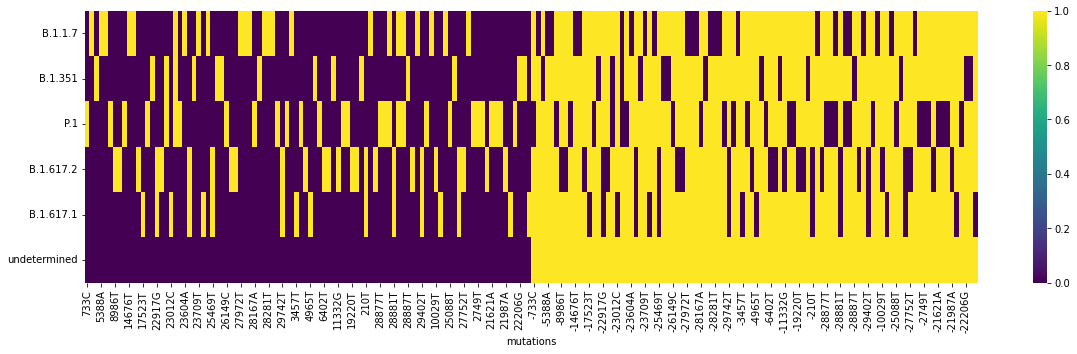

In [8]:
plt.figure(figsize=(20,5))
sns.heatmap(des_matrix.T, square=False, cmap="viridis")

/var/folders/yt/sy9k0v5j5614lbn7g01dkf6r0000gn/T/ipykernel_32489/299087886.py:17: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


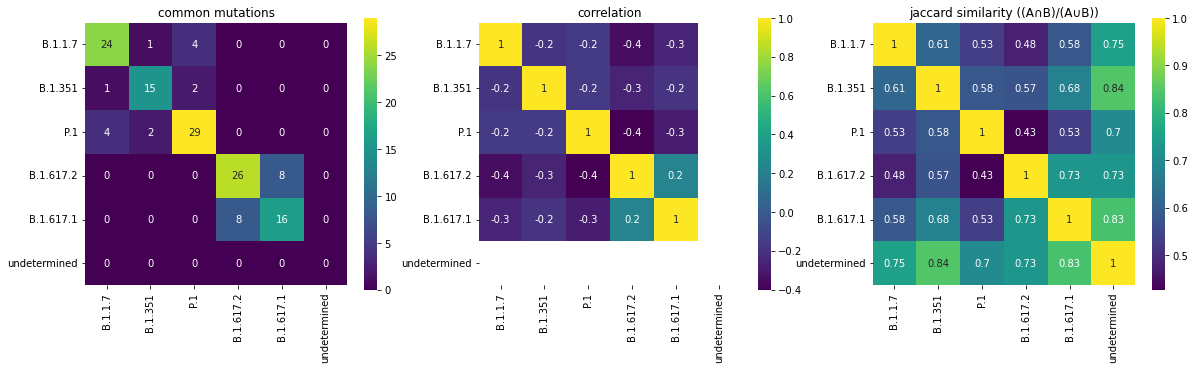

In [9]:
fig, axes = plt.subplots(1,3, figsize=(20,5))

common_mut = des_matrix_mut.T.dot(des_matrix_mut)
sns.heatmap(common_mut, square=True, cmap="viridis", annot=common_mut, ax=axes[0])
axes[0].set_title("common mutations")

corr_mut = (des_matrix_mut).corr()
sns.heatmap(corr_mut, square=True, cmap="viridis", annot=corr_mut, ax=axes[1], fmt=".1g")
axes[1].set_title("correlation")

from sklearn.metrics.pairwise import pairwise_distances
jac_sim = 1 - pairwise_distances(des_matrix_mut.T, metric = "hamming")
jac_sim = pd.DataFrame(jac_sim, index=des_matrix_mut.columns, columns=des_matrix_mut.columns)
sns.heatmap(jac_sim, square=True, cmap="viridis", annot=jac_sim, ax=axes[2])
axes[2].set_title("jaccard similarity ((A∩B)/(A∪B))")

fig.show()

# Run deconvolution

## Do it with linear reg / LS loss

### Run without producing confidence intervals

In [10]:
%%time

np.random.seed(42)
linear_deconv = []

for city in tqdm(cities_list):
    print(city)
    temp_df2 = preproc.df_tally[preproc.df_tally["plantname"] == city]
    t_kdec = KernelDeconv(
        temp_df2[variants_list + ["undetermined"]],
        temp_df2["frac"],
        temp_df2["date"],
#         weights=temp_df2["resample_value"],
        kernel=GaussianKernel(10),
        reg=NnlsReg(),
        confint=NullConfint()
    )
    t_kdec = t_kdec.deconv_all()
    res = t_kdec.fitted
    res["city"] = city
    linear_deconv.append(res)
linear_deconv_df = pd.concat(linear_deconv)
linear_deconv_df = linear_deconv_df.fillna(0)

linear_deconv_df_flat = linear_deconv_df.melt(
    id_vars="city",
    value_vars=variants_list + ["undetermined"],
    var_name="variant",
    value_name="frac",
    ignore_index=False,
)

# backup data
# linear_deconv2_df.to_csv("linear_deconv2.csv")

  0%|          | 0/6 [00:00<?, ?it/s]

Lugano (TI)
Zürich (ZH)
Chur (GR)
Altenrhein (SG)
Laupen (BE)
Lausanne (VD)
CPU times: user 2.1 s, sys: 62 ms, total: 2.16 s
Wall time: 2.2 s


### Do with Wald Confints

In [11]:
%%time

np.random.seed(42)
linear_deconv = []

for city in tqdm(cities_list):
    print(city)
    temp_df2 = preproc.df_tally[preproc.df_tally["plantname"] == city]
    t_kdec = KernelDeconv(
        temp_df2[variants_list + ["undetermined"]],
        temp_df2["frac"],
        temp_df2["date"],
#         weights=temp_df2["resample_value"],
        kernel=GaussianKernel(30),
        reg=NnlsReg(),
        confint=WaldConfint()
    )
    t_kdec = t_kdec.deconv_all(min_tol=1e-3)
    
    # save results
    res = t_kdec.renormalize().fitted.copy()
    res["city"] = city
    res["estimate"] = "MSE"
    linear_deconv.append(res)
    
    res_lower = t_kdec.renormalize().conf_bands["lower"].copy()
    res_lower["city"] = city
    res_lower["estimate"] = "Wald_lower"
    linear_deconv.append(res_lower)
    
    res_upper = t_kdec.renormalize().conf_bands["upper"].copy()
    res_upper["city"] = city
    res_upper["estimate"] = "Wald_upper"
    linear_deconv.append(res_upper)
    
linear_deconv_df = pd.concat(linear_deconv)
# linear_deconv_df = linear_deconv2_df.fillna(0)

linear_deconv_df_flat = linear_deconv_df.melt(
    id_vars=["city", "estimate"],
    value_vars=variants_list + ["undetermined"],
    var_name="variant",
    value_name="frac",
    ignore_index=False,
)
linear_deconv_df_flat.head()


# backup data
# linear_deconv2_df.to_csv("linear_deconv2.csv")

  0%|          | 0/6 [00:00<?, ?it/s]

Lugano (TI)
Zürich (ZH)
Chur (GR)
Altenrhein (SG)
Laupen (BE)
Lausanne (VD)
CPU times: user 2min 5s, sys: 3min 37s, total: 5min 43s
Wall time: 1min 5s


city estimate  variant      frac
2021-08-25  Lugano (TI)      MSE  B.1.1.7  0.002714
2021-08-26  Lugano (TI)      MSE  B.1.1.7  0.002670
2021-08-27  Lugano (TI)      MSE  B.1.1.7  0.002699
2021-08-28  Lugano (TI)      MSE  B.1.1.7  0.002783
2021-08-29  Lugano (TI)      MSE  B.1.1.7  0.002902

### Plot

Text(0.5, 0.98, 'Gaussian Kernel Deconvolution ($k=30$)')

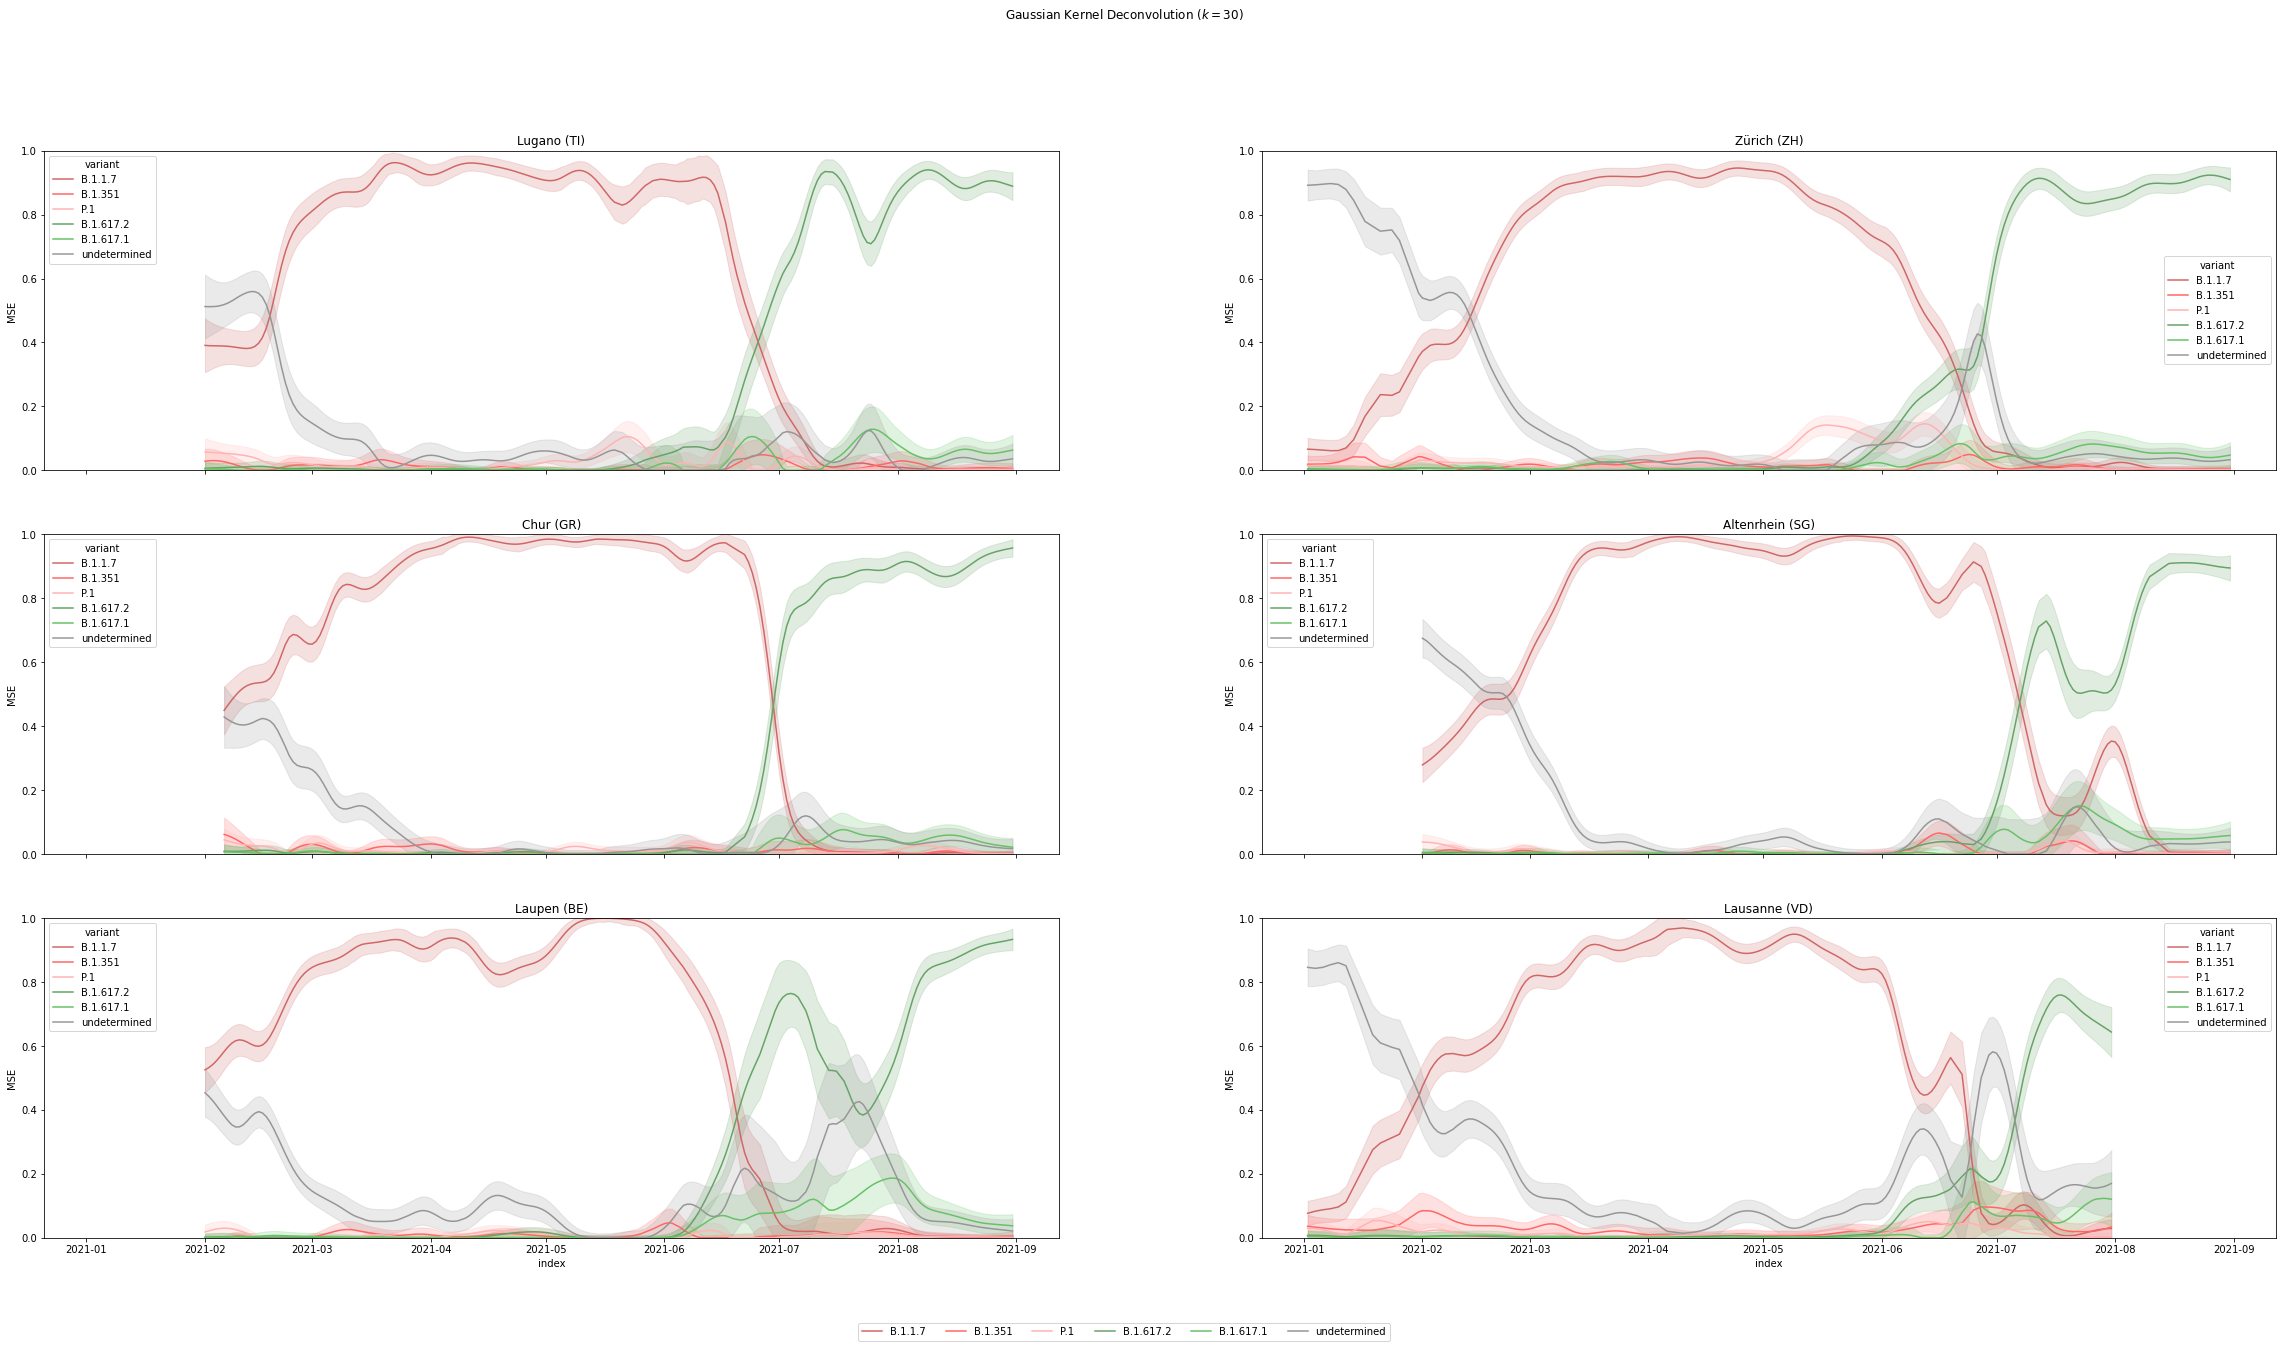

In [12]:
fig, axes = plt.subplots(nrows=3, ncols=2, figsize=(plotwidth, plotwidth/2), sharex=True)
axes = axes.flatten()

for i, city in enumerate(linear_deconv_df.city.unique()):
    axes[i].set_title(city)
    
    for var in linear_deconv_df_flat["variant"].unique():
        tt_df = linear_deconv_df_flat[
            (linear_deconv_df_flat["variant"] == var) &
            (linear_deconv_df_flat["city"] == city) 
        ].reset_index().pivot(
            index=["index", "city", "variant"],
            columns="estimate"
        ).reset_index()
        
        sns.lineplot(
            x=tt_df["index"], 
            y=tt_df["frac"]["MSE"], 
            hue=tt_df["variant"],
            ax = axes[i], 
            palette = color_map
        )
        axes[i].fill_between(
            x=tt_df["index"], 
            y1=tt_df["frac"]["Wald_lower"], 
            y2=tt_df["frac"]["Wald_upper"],
            alpha = 0.2,
            #color="grey"
            color=color_map[var],
        )
    axes[i].set_ylim((0,1))
handles, labels = axes[i].get_legend_handles_labels()
fig.legend(handles, labels, loc='lower center', ncol=len(labels), bbox_to_anchor=(0.5,0.05))
fig.suptitle(f'Gaussian Kernel Deconvolution ($k=30$)')
# plt.savefig(os.path.join(plots_dir, f"combined-linear.pdf"))

### Wald confints, quasibinomial

In [13]:
%%time

np.random.seed(42)
linear_deconv_quasi = []

for city in tqdm(cities_list):
    print(city)
    temp_df2 = preproc.df_tally[preproc.df_tally["plantname"] == city]
    t_kdec = KernelDeconv(
        temp_df2[variants_list + ["undetermined"]],
        temp_df2["frac"],
        temp_df2["date"],
#         weights=temp_df2["resample_value"],
        kernel=GaussianKernel(30),
        reg=NnlsReg(),
        confint=WaldConfint(quasi=True)
    )
    t_kdec = t_kdec.deconv_all(min_tol=1e-3)
    
    # save results
    res = t_kdec.renormalize().fitted.copy()
    res["city"] = city
    res["estimate"] = "MSE"
    linear_deconv_quasi.append(res)
    
    res_lower = t_kdec.renormalize().conf_bands["lower"].copy()
    res_lower["city"] = city
    res_lower["estimate"] = "Wald_lower"
    linear_deconv_quasi.append(res_lower)
    
    res_upper = t_kdec.renormalize().conf_bands["upper"].copy()
    res_upper["city"] = city
    res_upper["estimate"] = "Wald_upper"
    linear_deconv_quasi.append(res_upper)
    
linear_deconv_quasi_df = pd.concat(linear_deconv_quasi)
# linear_deconv_df = linear_deconv2_df.fillna(0)

linear_deconv_quasi_df_flat = linear_deconv_quasi_df.melt(
    id_vars=["city", "estimate"],
    value_vars=variants_list + ["undetermined"],
    var_name="variant",
    value_name="frac",
    ignore_index=False,
)
linear_deconv_quasi_df_flat.head()


# backup data
# linear_deconv2_df.to_csv("linear_deconv2.csv")

  0%|          | 0/6 [00:00<?, ?it/s]

Lugano (TI)
Zürich (ZH)
Chur (GR)
Altenrhein (SG)
Laupen (BE)
Lausanne (VD)
CPU times: user 2min 2s, sys: 3min 31s, total: 5min 34s
Wall time: 1min 8s


city estimate  variant      frac
2021-08-25  Lugano (TI)      MSE  B.1.1.7  0.002714
2021-08-26  Lugano (TI)      MSE  B.1.1.7  0.002670
2021-08-27  Lugano (TI)      MSE  B.1.1.7  0.002699
2021-08-28  Lugano (TI)      MSE  B.1.1.7  0.002783
2021-08-29  Lugano (TI)      MSE  B.1.1.7  0.002902

Text(0.5, 0.98, 'Gaussian Kernel Deconvolution ($k=30$)')

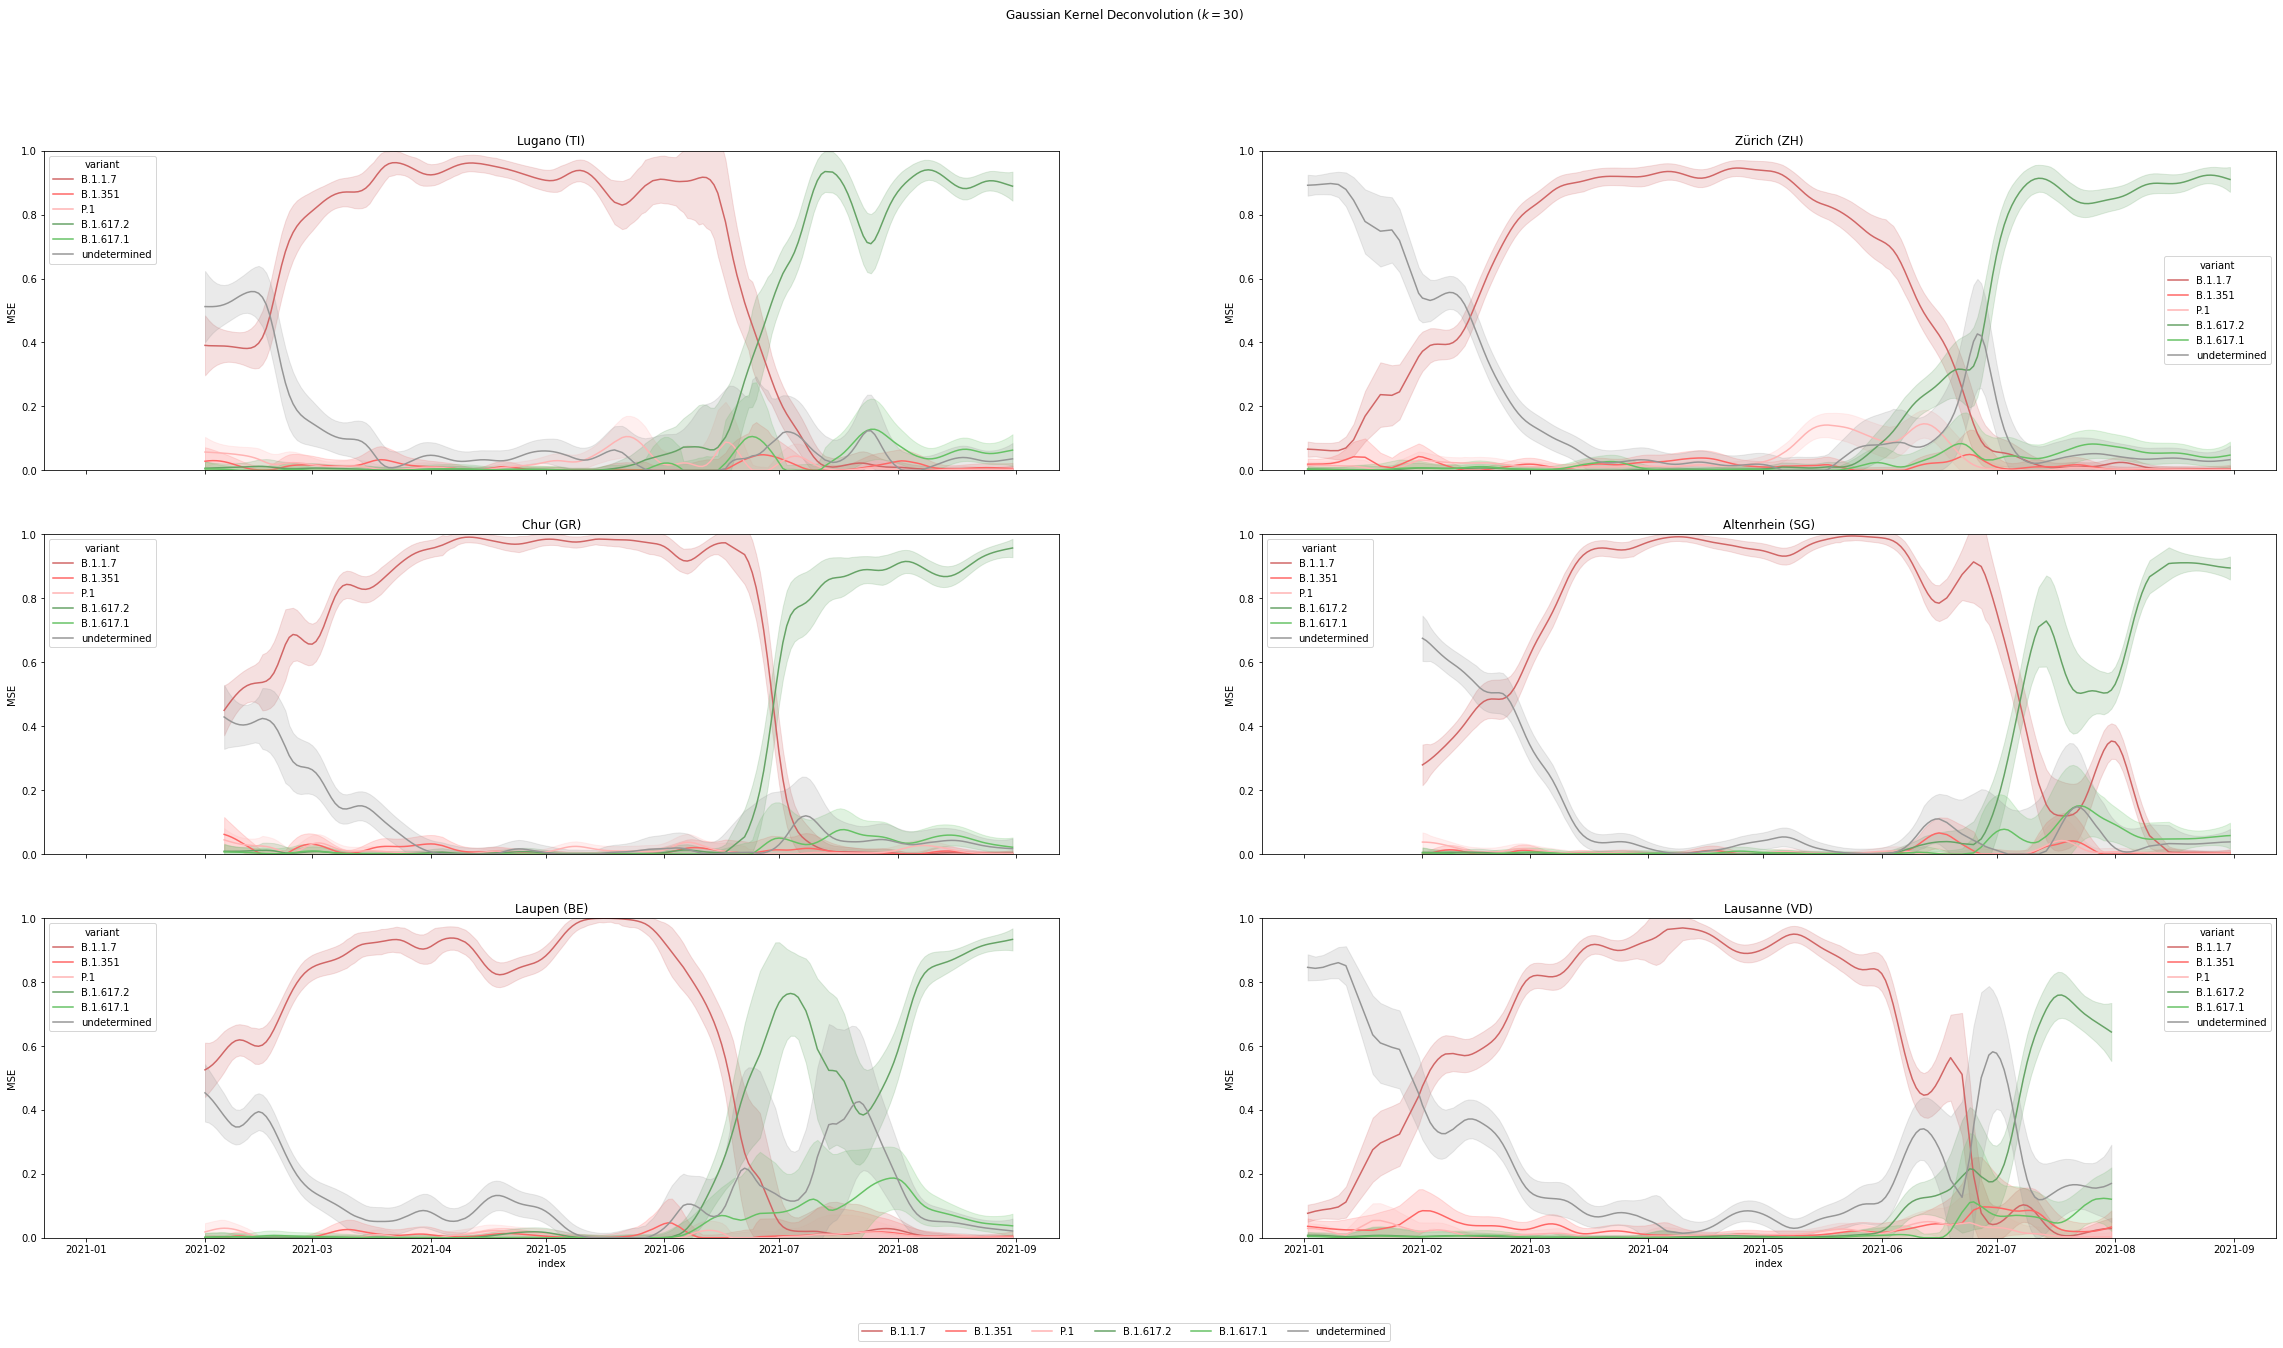

In [14]:
fig, axes = plt.subplots(nrows=3, ncols=2, figsize=(plotwidth, plotwidth/2), sharex=True)
axes = axes.flatten()

for i, city in enumerate(linear_deconv_quasi_df_flat.city.unique()):
    axes[i].set_title(city)
    axes[i].set_ylim(0,1)
    
    for var in linear_deconv_quasi_df_flat["variant"].unique():
        tt_df = linear_deconv_quasi_df_flat[
            (linear_deconv_quasi_df_flat["variant"] == var) &
            (linear_deconv_quasi_df_flat["city"] == city) 
        ].reset_index().pivot(
            index=["index", "city", "variant"],
            columns="estimate"
        ).reset_index()
        
        sns.lineplot(
            x=tt_df["index"], 
            y=tt_df["frac"]["MSE"], 
            hue=tt_df["variant"],
            ax = axes[i], 
            palette = color_map
        )
        axes[i].fill_between(
            x=tt_df["index"], 
            y1=tt_df["frac"]["Wald_lower"], 
            y2=tt_df["frac"]["Wald_upper"],
            alpha = 0.2,
            #color="grey"
            color=color_map[var],
        )
handles, labels = axes[i].get_legend_handles_labels()
fig.legend(handles, labels, loc='lower center', ncol=len(labels), bbox_to_anchor=(0.5,0.05))
fig.suptitle(f'Gaussian Kernel Deconvolution ($k=30$)')
# plt.savefig(os.path.join(plots_dir, f"combined-linear.pdf"))

### Wald confint, quasibinomial stratified

In [15]:
%%time

np.random.seed(42)
linear_deconv_quasi2 = []

for city in tqdm(cities_list):
    print(city)
    temp_df2 = preproc.df_tally[preproc.df_tally["plantname"] == city]
    t_kdec = KernelDeconv(
        temp_df2[variants_list + ["undetermined"]],
        temp_df2["frac"],
        temp_df2["date"],
#         weights=temp_df2["resample_value"],
        kernel=GaussianKernel(30),
        reg=NnlsReg(),
        confint=WaldConfint(quasi=True, method="strat")
    )
    t_kdec = t_kdec.deconv_all(min_tol=1e-3)
    
    # save results
    res = t_kdec.renormalize().fitted.copy()
    res["city"] = city
    res["estimate"] = "MSE"
    linear_deconv_quasi2.append(res)
    
    res_lower = t_kdec.renormalize().conf_bands["lower"].copy()
    res_lower["city"] = city
    res_lower["estimate"] = "Wald_lower"
    linear_deconv_quasi2.append(res_lower)
    
    res_upper = t_kdec.renormalize().conf_bands["upper"].copy()
    res_upper["city"] = city
    res_upper["estimate"] = "Wald_upper"
    linear_deconv_quasi2.append(res_upper)
    
linear_deconv_quasi2_df = pd.concat(linear_deconv_quasi2)
# linear_deconv_df = linear_deconv2_df.fillna(0)

linear_deconv_quasi2_df_flat = linear_deconv_quasi2_df.melt(
    id_vars=["city", "estimate"],
    value_vars=variants_list + ["undetermined"],
    var_name="variant",
    value_name="frac",
    ignore_index=False,
)
linear_deconv_quasi2_df_flat.head()


# backup data
# linear_deconv2_df.to_csv("linear_deconv2.csv")

  0%|          | 0/6 [00:00<?, ?it/s]

Lugano (TI)


/Users/gneiss/Documents/School/CBG2/brexit/TSmodelling/WWdeconvolution/RECOMBpaper/../Dev/WWdec/confints.py:54: RuntimeWarning: invalid value encountered in true_divide
  overdisp_agg = (np.expand_dims(overdisp_vals,1) * X[mut_ind,:]).sum(axis=0)  / norm


Zürich (ZH)


/Users/gneiss/Documents/School/CBG2/brexit/TSmodelling/WWdeconvolution/RECOMBpaper/../Dev/WWdec/confints.py:54: RuntimeWarning: invalid value encountered in true_divide
  overdisp_agg = (np.expand_dims(overdisp_vals,1) * X[mut_ind,:]).sum(axis=0)  / norm


Chur (GR)


/Users/gneiss/Documents/School/CBG2/brexit/TSmodelling/WWdeconvolution/RECOMBpaper/../Dev/WWdec/confints.py:54: RuntimeWarning: invalid value encountered in true_divide
  overdisp_agg = (np.expand_dims(overdisp_vals,1) * X[mut_ind,:]).sum(axis=0)  / norm


Altenrhein (SG)


/Users/gneiss/Documents/School/CBG2/brexit/TSmodelling/WWdeconvolution/RECOMBpaper/../Dev/WWdec/confints.py:54: RuntimeWarning: invalid value encountered in true_divide
  overdisp_agg = (np.expand_dims(overdisp_vals,1) * X[mut_ind,:]).sum(axis=0)  / norm


Laupen (BE)


/Users/gneiss/Documents/School/CBG2/brexit/TSmodelling/WWdeconvolution/RECOMBpaper/../Dev/WWdec/confints.py:54: RuntimeWarning: invalid value encountered in true_divide
  overdisp_agg = (np.expand_dims(overdisp_vals,1) * X[mut_ind,:]).sum(axis=0)  / norm


Lausanne (VD)


/Users/gneiss/Documents/School/CBG2/brexit/TSmodelling/WWdeconvolution/RECOMBpaper/../Dev/WWdec/confints.py:54: RuntimeWarning: invalid value encountered in true_divide
  overdisp_agg = (np.expand_dims(overdisp_vals,1) * X[mut_ind,:]).sum(axis=0)  / norm


CPU times: user 2min 3s, sys: 3min 26s, total: 5min 30s
Wall time: 1min 9s


city estimate  variant      frac
2021-08-25  Lugano (TI)      MSE  B.1.1.7  0.002714
2021-08-26  Lugano (TI)      MSE  B.1.1.7  0.002670
2021-08-27  Lugano (TI)      MSE  B.1.1.7  0.002699
2021-08-28  Lugano (TI)      MSE  B.1.1.7  0.002783
2021-08-29  Lugano (TI)      MSE  B.1.1.7  0.002902

#### Plot

Text(0.5, 0.98, 'Gaussian Kernel Deconvolution ($k=30$)')

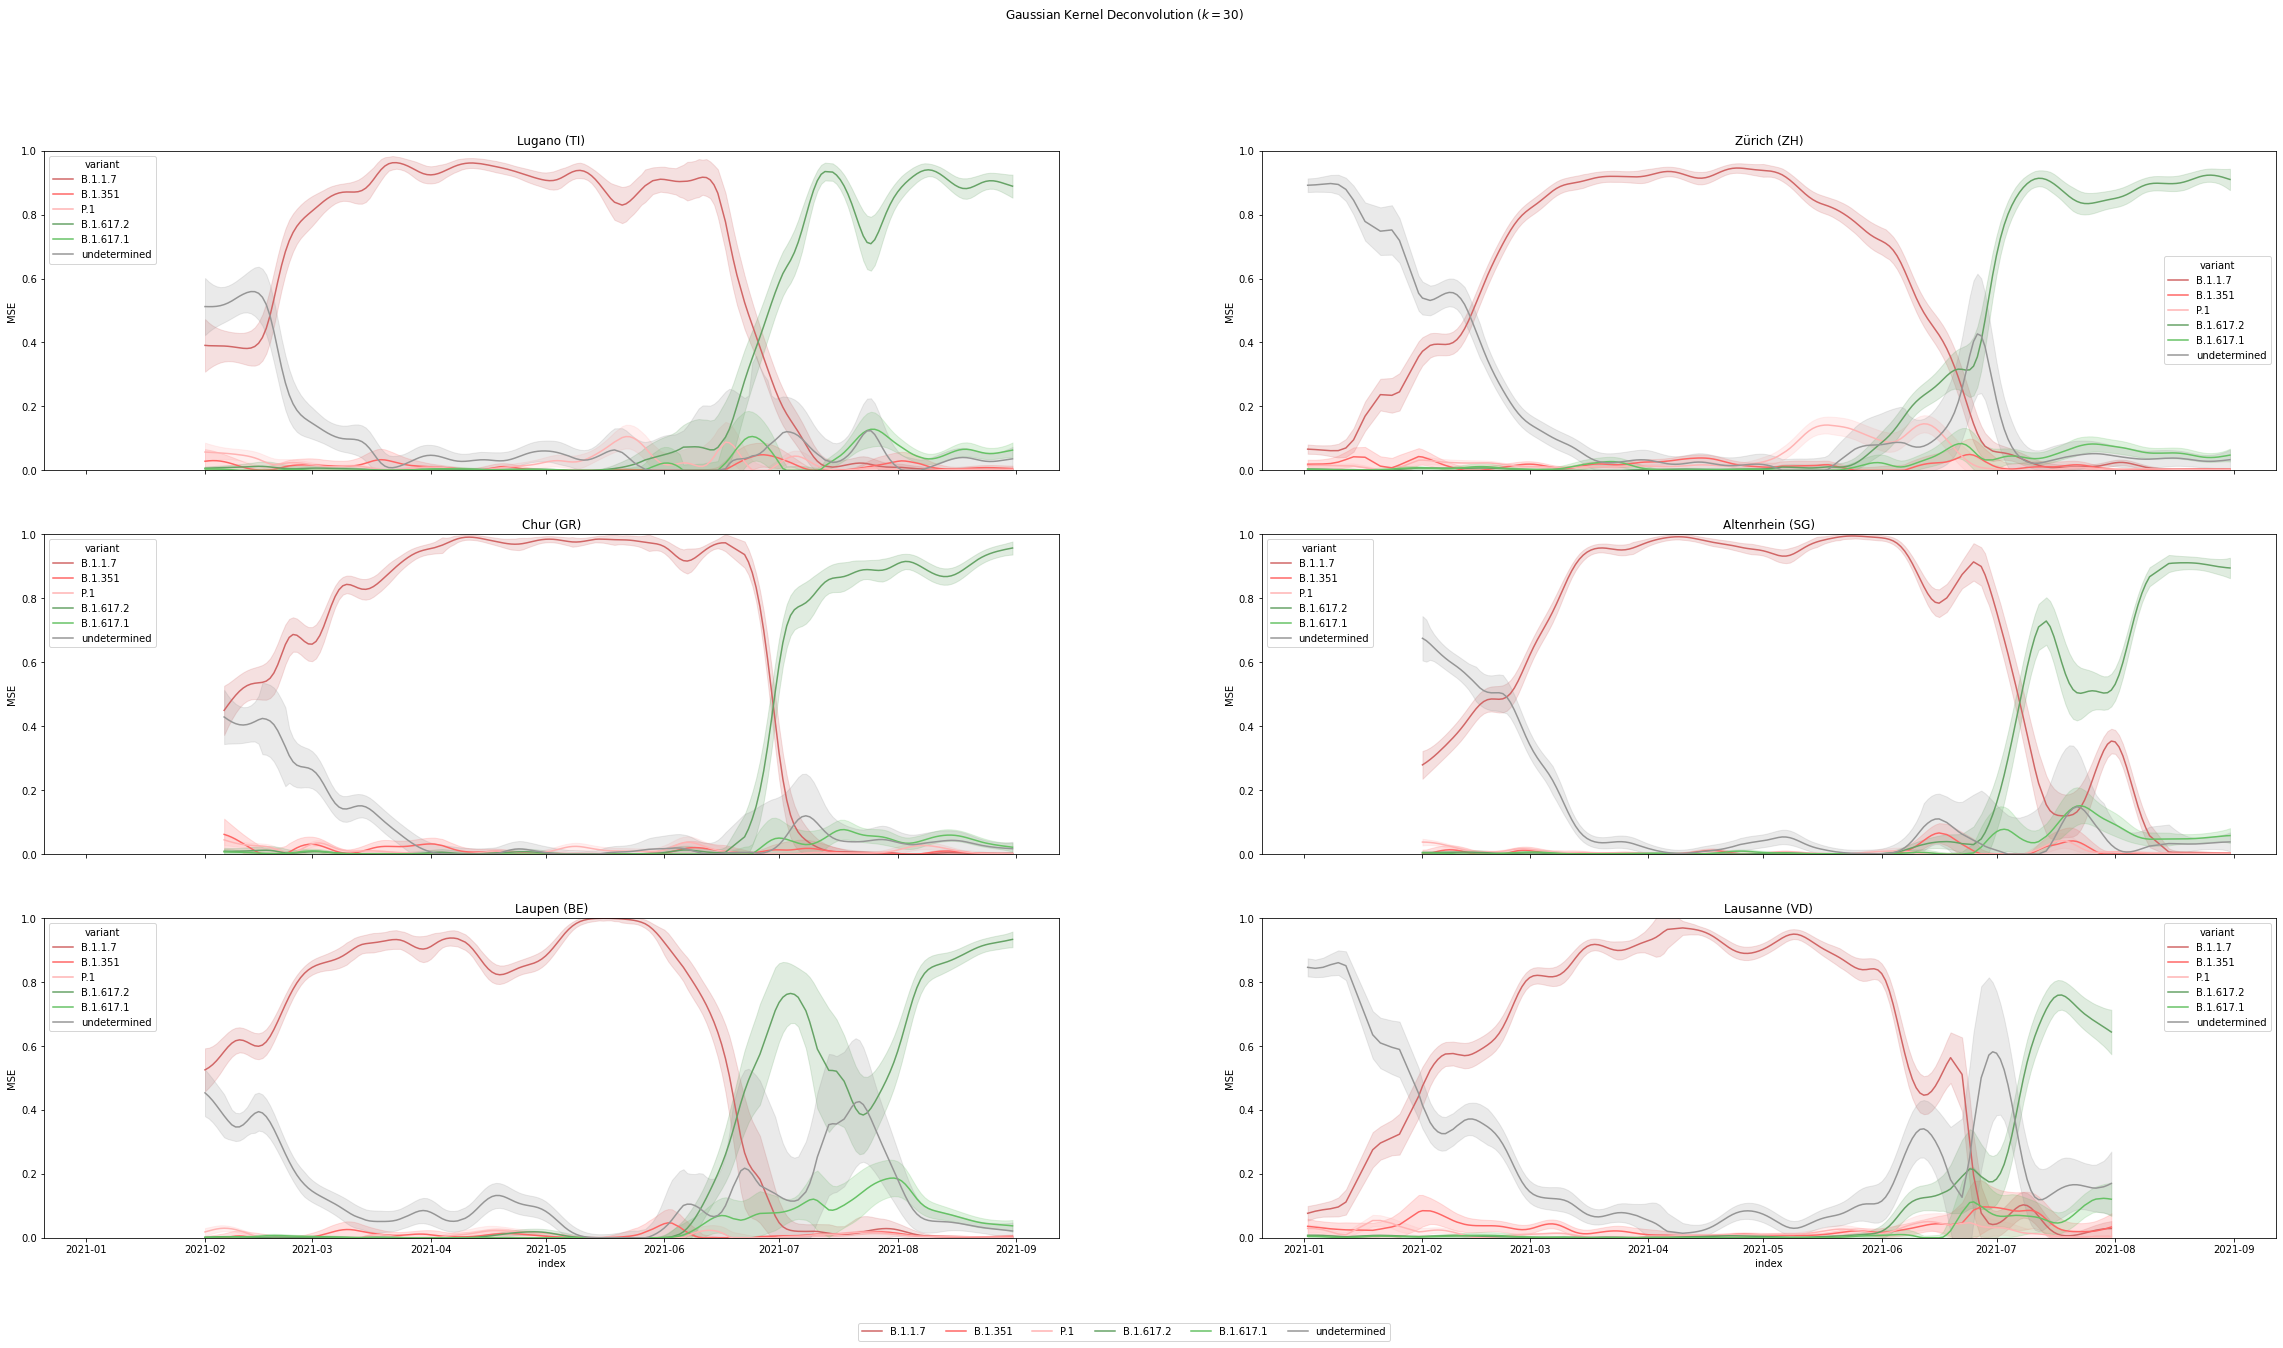

In [16]:
fig, axes = plt.subplots(nrows=3, ncols=2, figsize=(plotwidth, plotwidth/2), sharex=True)
axes = axes.flatten()

for i, city in enumerate(linear_deconv_quasi2_df_flat.city.unique()):
    axes[i].set_title(city)
    axes[i].set_ylim(0,1)
    
    for var in linear_deconv_quasi2_df_flat["variant"].unique():
        tt_df = linear_deconv_quasi2_df_flat[
            (linear_deconv_quasi2_df_flat["variant"] == var) &
            (linear_deconv_quasi2_df_flat["city"] == city) 
        ].reset_index().pivot(
            index=["index", "city", "variant"],
            columns="estimate"
        ).reset_index()
        
        sns.lineplot(
            x=tt_df["index"], 
            y=tt_df["frac"]["MSE"], 
            hue=tt_df["variant"],
            ax = axes[i], 
            palette = color_map
        )
        axes[i].fill_between(
            x=tt_df["index"], 
            y1=tt_df["frac"]["Wald_lower"], 
            y2=tt_df["frac"]["Wald_upper"],
            alpha = 0.2,
            #color="grey"
            color=color_map[var],
        )
handles, labels = axes[i].get_legend_handles_labels()
fig.legend(handles, labels, loc='lower center', ncol=len(labels), bbox_to_anchor=(0.5,0.05))
fig.suptitle(f'Gaussian Kernel Deconvolution ($k=30$)')
# plt.savefig(os.path.join(plots_dir, f"combined-linear.pdf"))

### Logit parametrized Wald confints

In [17]:
%%time

np.random.seed(42)
linear_deconv2 = []

for city in tqdm(cities_list):
    print(city)
    temp_df2 = preproc.df_tally[preproc.df_tally["plantname"] == city]
    t_kdec = KernelDeconv(
        temp_df2[variants_list + ["undetermined"]],
        temp_df2["frac"],
        temp_df2["date"],
#         weights=temp_df2["resample_value"],
        kernel=GaussianKernel(30),
        reg=NnlsReg(),
        confint=WaldConfint(
            scale="logit",
            pseudofrac=0.01
        )
    )
    t_kdec = t_kdec.deconv_all(min_tol=1e-3)
    
    # save results
    res = t_kdec.fitted.copy()
    res["city"] = city
    res["estimate"] = "MSE"
    linear_deconv2.append(res)
    
    res_lower = t_kdec.conf_bands["lower"].copy()
    res_lower["city"] = city
    res_lower["estimate"] = "Wald_lower"
    linear_deconv2.append(res_lower)
    
    res_upper = t_kdec.conf_bands["upper"].copy()
    res_upper["city"] = city
    res_upper["estimate"] = "Wald_upper"
    linear_deconv2.append(res_upper)
    

linear_deconv2_df = pd.concat(linear_deconv2)
# linear_deconv_df = linear_deconv2_df.fillna(0)

linear_deconv2_df_flat = linear_deconv2_df.melt(
    id_vars=["city", "estimate"],
    value_vars=variants_list + ["undetermined"],
    var_name="variant",
    value_name="frac",
    ignore_index=False,
)
linear_deconv2_df_flat.head()


# backup data
# linear_deconv2_df.to_csv("linear_deconv2.csv")

  0%|          | 0/6 [00:00<?, ?it/s]

Lugano (TI)


/Users/gneiss/Documents/School/CBG2/brexit/TSmodelling/WWdeconvolution/RECOMBpaper/../Dev/WWdec/confints.py:134: RuntimeWarning: divide by zero encountered in log
  logit_fitted = np.log(coefs) - np.log(1-coefs)


Zürich (ZH)


/Users/gneiss/Documents/School/CBG2/brexit/TSmodelling/WWdeconvolution/RECOMBpaper/../Dev/WWdec/confints.py:134: RuntimeWarning: divide by zero encountered in log
  logit_fitted = np.log(coefs) - np.log(1-coefs)


Chur (GR)


/Users/gneiss/Documents/School/CBG2/brexit/TSmodelling/WWdeconvolution/RECOMBpaper/../Dev/WWdec/confints.py:134: RuntimeWarning: divide by zero encountered in log
  logit_fitted = np.log(coefs) - np.log(1-coefs)


Altenrhein (SG)


/Users/gneiss/Documents/School/CBG2/brexit/TSmodelling/WWdeconvolution/RECOMBpaper/../Dev/WWdec/confints.py:134: RuntimeWarning: divide by zero encountered in log
  logit_fitted = np.log(coefs) - np.log(1-coefs)


Laupen (BE)


/Users/gneiss/Documents/School/CBG2/brexit/TSmodelling/WWdeconvolution/RECOMBpaper/../Dev/WWdec/confints.py:134: RuntimeWarning: divide by zero encountered in log
  logit_fitted = np.log(coefs) - np.log(1-coefs)


Lausanne (VD)


/Users/gneiss/Documents/School/CBG2/brexit/TSmodelling/WWdeconvolution/RECOMBpaper/../Dev/WWdec/confints.py:134: RuntimeWarning: divide by zero encountered in log
  logit_fitted = np.log(coefs) - np.log(1-coefs)


CPU times: user 2min 25s, sys: 3min 37s, total: 6min 2s
Wall time: 1min 13s


city estimate  variant      frac
2021-08-25  Lugano (TI)      MSE  B.1.1.7  0.002714
2021-08-26  Lugano (TI)      MSE  B.1.1.7  0.002670
2021-08-27  Lugano (TI)      MSE  B.1.1.7  0.002699
2021-08-28  Lugano (TI)      MSE  B.1.1.7  0.002783
2021-08-29  Lugano (TI)      MSE  B.1.1.7  0.002902

### Plot

Text(0.5, 0.98, 'Gaussian Kernel Deconvolution ($k=10$)')

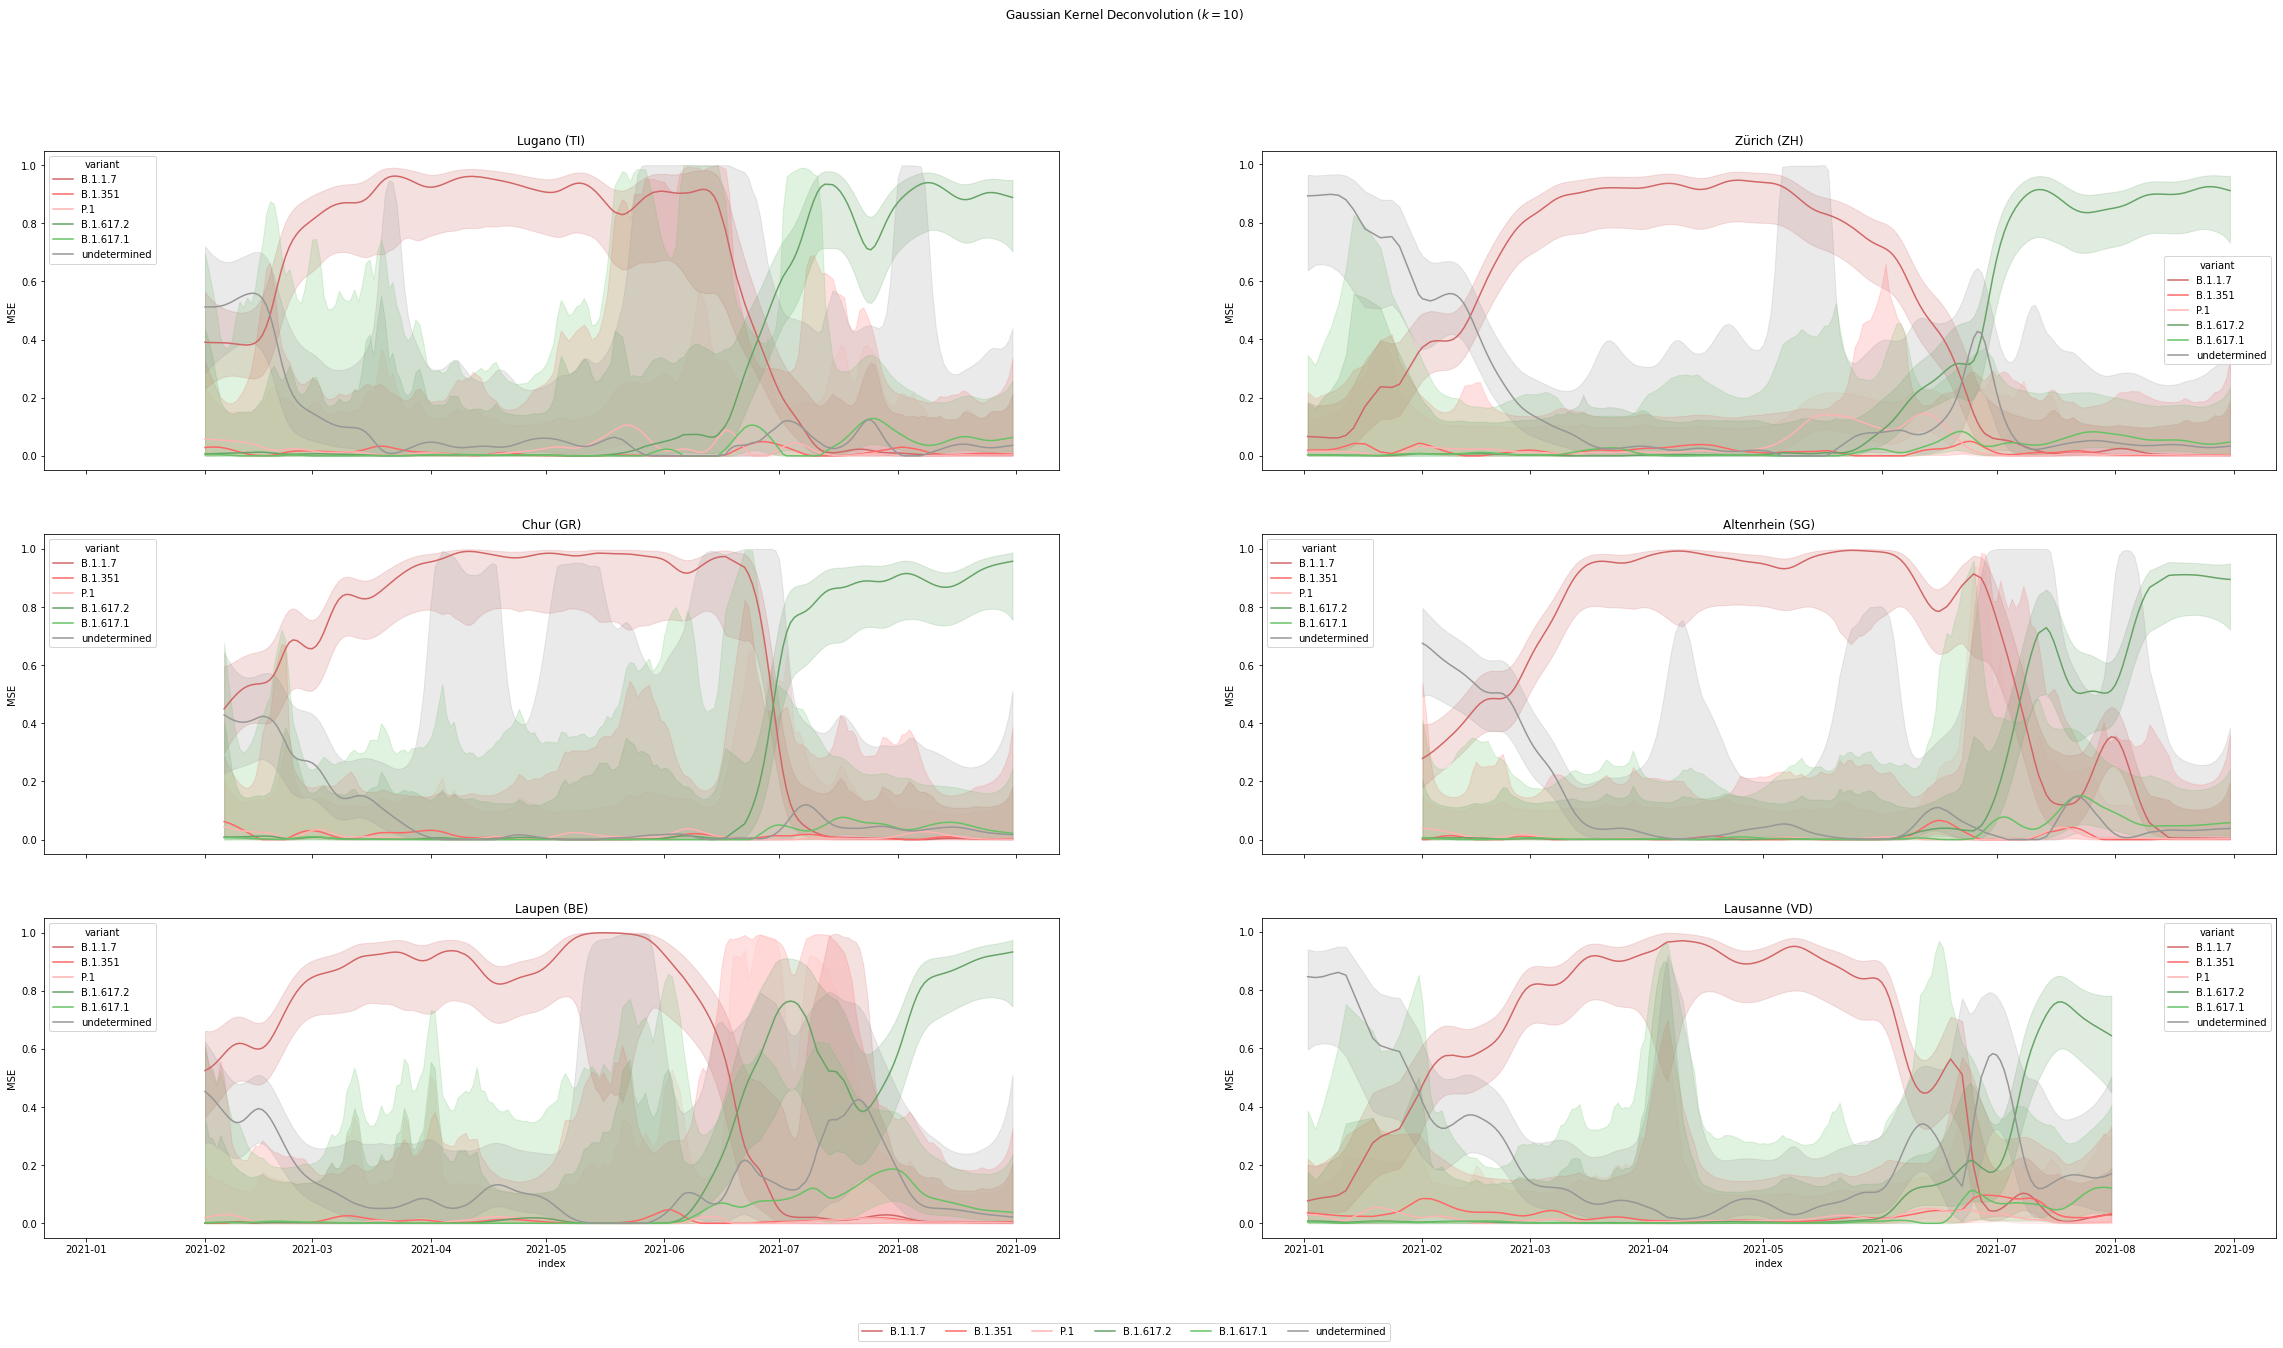

In [18]:
fig, axes = plt.subplots(nrows=3, ncols=2, figsize=(plotwidth, plotwidth/2), sharex=True)
axes = axes.flatten()

def logit_inv(x):
    return np.exp(x)/(1+np.exp(x))

for i, city in enumerate(linear_deconv2_df.city.unique()):
    axes[i].set_title(city)
    
    for var in linear_deconv2_df_flat["variant"].unique():
        tt_df = linear_deconv2_df_flat[
            (linear_deconv2_df_flat["variant"] == var) &
            (linear_deconv2_df_flat["city"] == city) 
        ].reset_index().pivot(
            index=["index", "city", "variant"],
            columns="estimate"
        ).reset_index()
        
        sns.lineplot(
            x=tt_df["index"], 
            y=tt_df["frac"]["MSE"], 
            hue=tt_df["variant"],
            ax = axes[i], 
            palette = color_map
        )
        axes[i].fill_between(
            x=tt_df["index"], 
            y1=logit_inv(np.clip(tt_df["frac"]["Wald_lower"], -100, 100)), 
            y2=logit_inv(np.clip(tt_df["frac"]["Wald_upper"], -100, 100)),
            alpha = 0.2,
            #color="grey"
            color=color_map[var],
        )
handles, labels = axes[i].get_legend_handles_labels()
fig.legend(handles, labels, loc='lower center', ncol=len(labels), bbox_to_anchor=(0.5,0.05))
fig.suptitle(f'Gaussian Kernel Deconvolution ($k=10$)')
# plt.savefig(os.path.join(plots_dir, f"combined-linear.pdf"))

### Logit parametrised confidence intervals with quasilikelihood

In [19]:
%%time

np.random.seed(42)
linear_deconv2_quasi = []

for city in tqdm(cities_list):
    print(city)
    temp_df2 = preproc.df_tally[preproc.df_tally["plantname"] == city]
    t_kdec = KernelDeconv(
        temp_df2[variants_list + ["undetermined"]],
        temp_df2["frac"],
        temp_df2["date"],
#         weights=temp_df2["resample_value"],
        kernel=GaussianKernel(30),
        reg=NnlsReg(),
        confint=WaldConfint(
            scale="logit",
            pseudofrac=0.01,
            quasi=True
        )
    )
    t_kdec = t_kdec.deconv_all(min_tol=1e-3)
    
    # save results
    res = t_kdec.fitted.copy()
    res["city"] = city
    res["estimate"] = "MSE"
    linear_deconv2_quasi.append(res)
    
    res_lower = t_kdec.conf_bands["lower"].copy()
    res_lower["city"] = city
    res_lower["estimate"] = "Wald_lower"
    linear_deconv2_quasi.append(res_lower)
    
    res_upper = t_kdec.conf_bands["upper"].copy()
    res_upper["city"] = city
    res_upper["estimate"] = "Wald_upper"
    linear_deconv2_quasi.append(res_upper)
    

linear_deconv2_quasi_df = pd.concat(linear_deconv2_quasi)
# linear_deconv_df = linear_deconv2_df.fillna(0)

linear_deconv2_quasi_df_flat = linear_deconv2_quasi_df.melt(
    id_vars=["city", "estimate"],
    value_vars=variants_list + ["undetermined"],
    var_name="variant",
    value_name="frac",
    ignore_index=False,
)
linear_deconv2_quasi_df_flat.head()


# backup data
# linear_deconv2_df.to_csv("linear_deconv2.csv")

  0%|          | 0/6 [00:00<?, ?it/s]

Lugano (TI)


/Users/gneiss/Documents/School/CBG2/brexit/TSmodelling/WWdeconvolution/RECOMBpaper/../Dev/WWdec/confints.py:134: RuntimeWarning: divide by zero encountered in log
  logit_fitted = np.log(coefs) - np.log(1-coefs)


Zürich (ZH)


/Users/gneiss/Documents/School/CBG2/brexit/TSmodelling/WWdeconvolution/RECOMBpaper/../Dev/WWdec/confints.py:134: RuntimeWarning: divide by zero encountered in log
  logit_fitted = np.log(coefs) - np.log(1-coefs)


Chur (GR)


/Users/gneiss/Documents/School/CBG2/brexit/TSmodelling/WWdeconvolution/RECOMBpaper/../Dev/WWdec/confints.py:134: RuntimeWarning: divide by zero encountered in log
  logit_fitted = np.log(coefs) - np.log(1-coefs)


Altenrhein (SG)


/Users/gneiss/Documents/School/CBG2/brexit/TSmodelling/WWdeconvolution/RECOMBpaper/../Dev/WWdec/confints.py:134: RuntimeWarning: divide by zero encountered in log
  logit_fitted = np.log(coefs) - np.log(1-coefs)


Laupen (BE)


/Users/gneiss/Documents/School/CBG2/brexit/TSmodelling/WWdeconvolution/RECOMBpaper/../Dev/WWdec/confints.py:134: RuntimeWarning: divide by zero encountered in log
  logit_fitted = np.log(coefs) - np.log(1-coefs)


Lausanne (VD)


/Users/gneiss/Documents/School/CBG2/brexit/TSmodelling/WWdeconvolution/RECOMBpaper/../Dev/WWdec/confints.py:134: RuntimeWarning: divide by zero encountered in log
  logit_fitted = np.log(coefs) - np.log(1-coefs)


CPU times: user 2min 12s, sys: 3min 40s, total: 5min 52s
Wall time: 1min 12s


city estimate  variant      frac
2021-08-25  Lugano (TI)      MSE  B.1.1.7  0.002714
2021-08-26  Lugano (TI)      MSE  B.1.1.7  0.002670
2021-08-27  Lugano (TI)      MSE  B.1.1.7  0.002699
2021-08-28  Lugano (TI)      MSE  B.1.1.7  0.002783
2021-08-29  Lugano (TI)      MSE  B.1.1.7  0.002902

#### plot

Text(0.5, 0.98, 'Gaussian Kernel Deconvolution ($k=10$)')

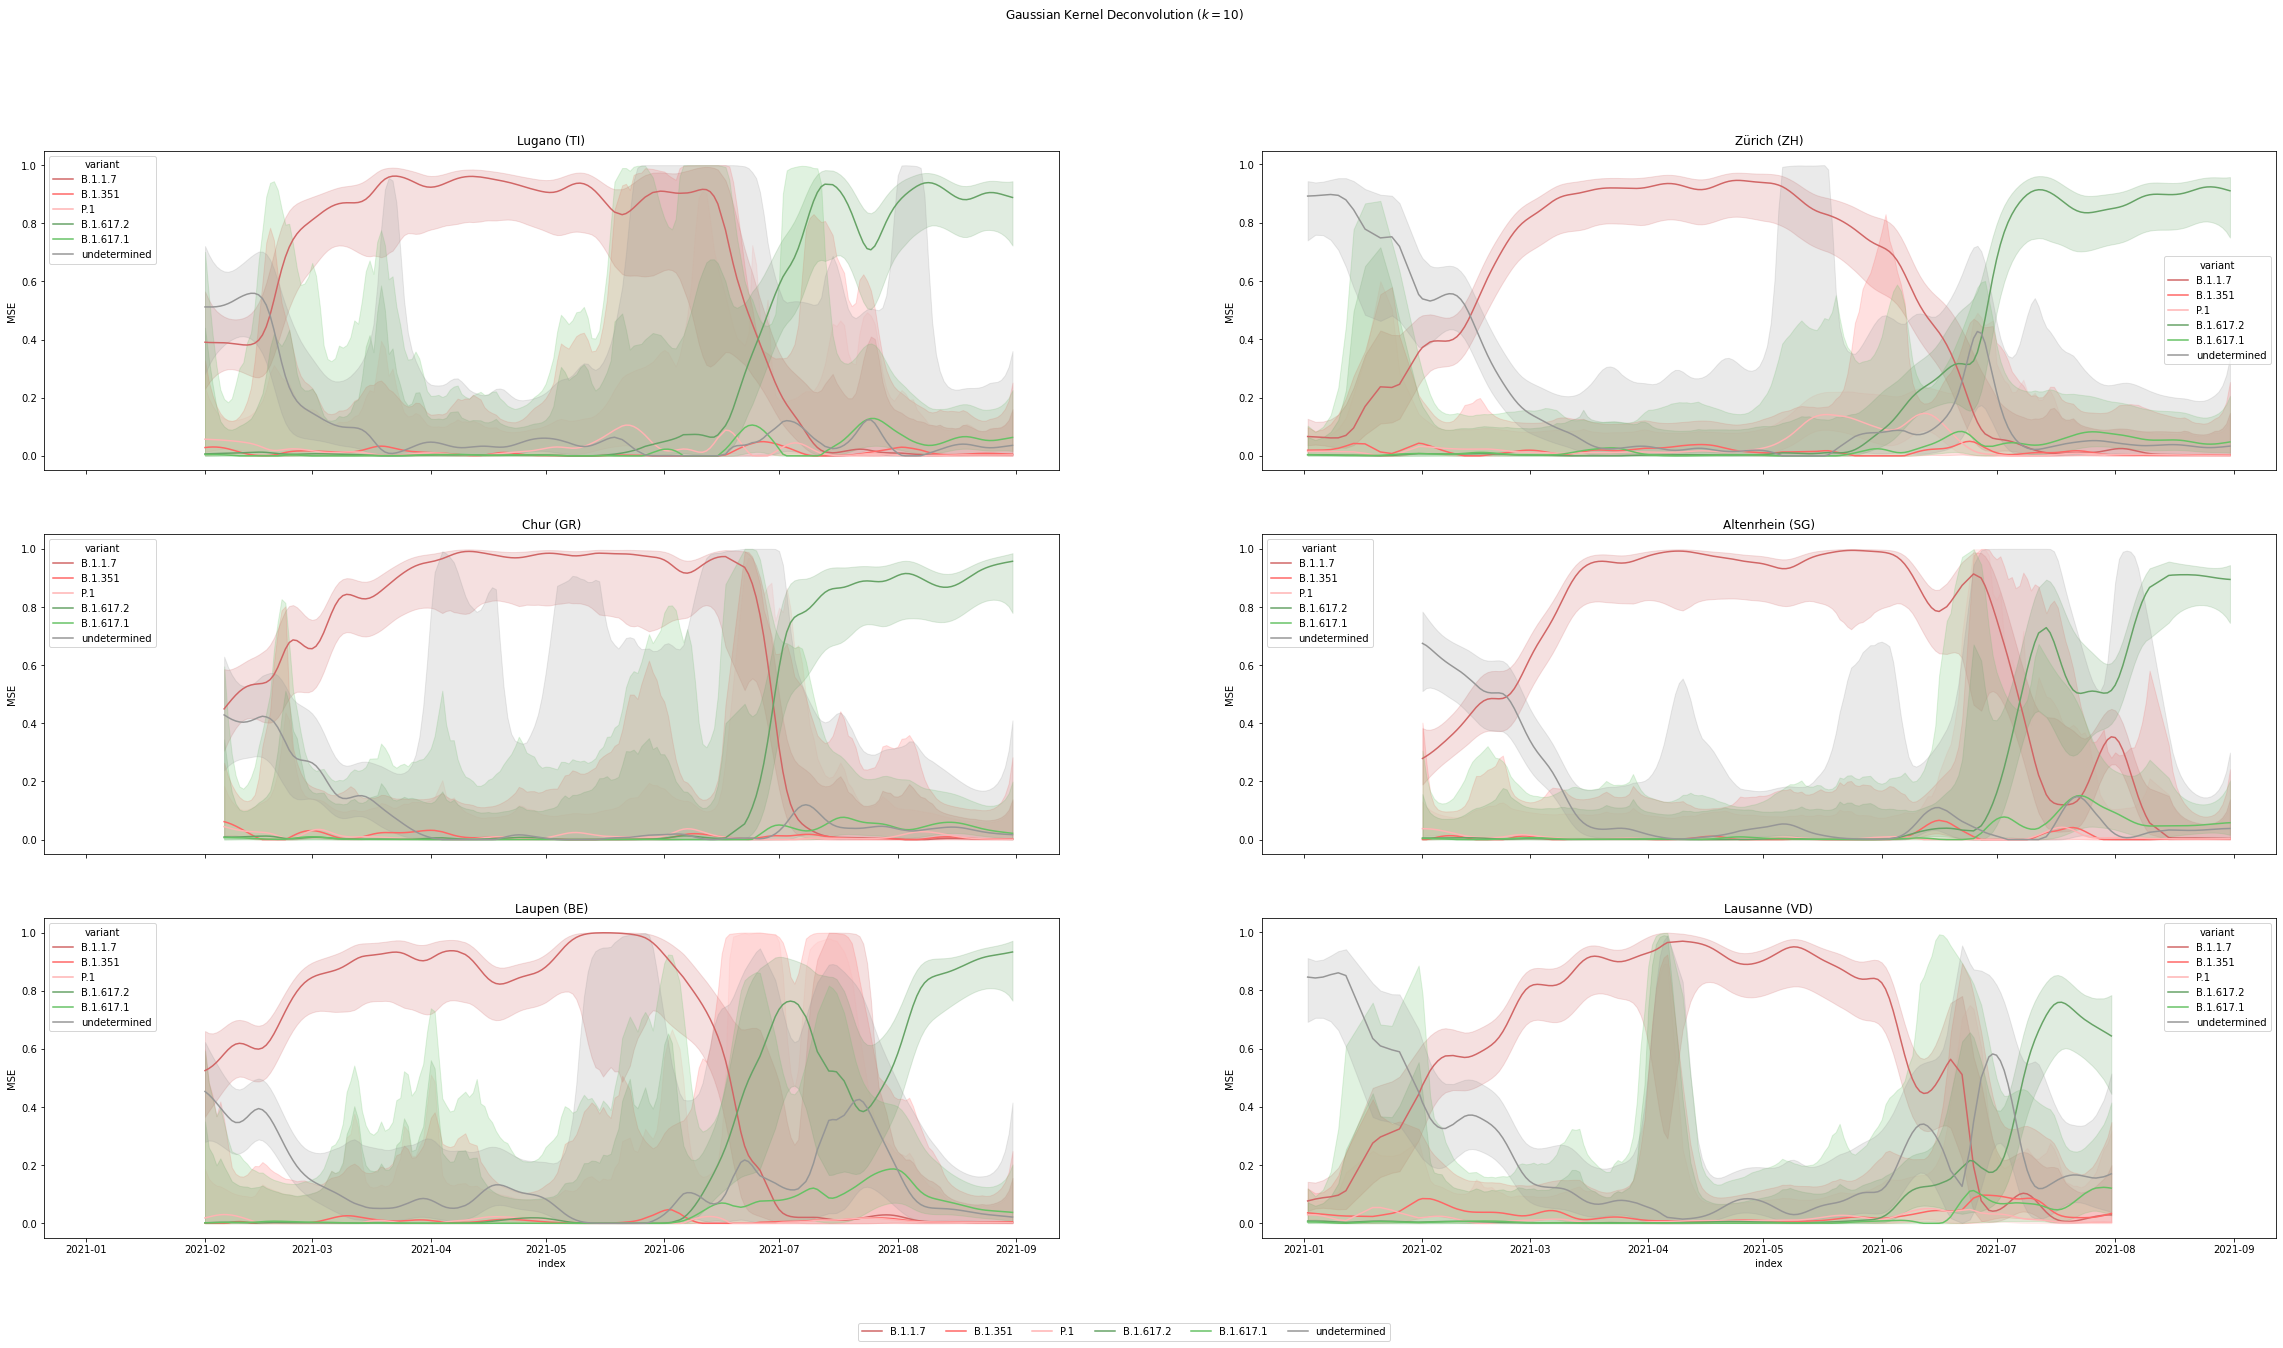

In [20]:
fig, axes = plt.subplots(nrows=3, ncols=2, figsize=(plotwidth, plotwidth/2), sharex=True)
axes = axes.flatten()

def logit_inv(x):
    return np.exp(x)/(1+np.exp(x))

for i, city in enumerate(linear_deconv2_quasi_df_flat.city.unique()):
    axes[i].set_title(city)
    
    for var in linear_deconv2_quasi_df_flat["variant"].unique():
        tt_df = linear_deconv2_quasi_df_flat[
            (linear_deconv2_quasi_df_flat["variant"] == var) &
            (linear_deconv2_quasi_df_flat["city"] == city) 
        ].reset_index().pivot(
            index=["index", "city", "variant"],
            columns="estimate"
        ).reset_index()
        
        sns.lineplot(
            x=tt_df["index"], 
            y=tt_df["frac"]["MSE"], 
            hue=tt_df["variant"],
            ax = axes[i], 
            palette = color_map
        )
        axes[i].fill_between(
            x=tt_df["index"], 
            y1=logit_inv(np.clip(tt_df["frac"]["Wald_lower"], -100, 100)), 
            y2=logit_inv(np.clip(tt_df["frac"]["Wald_upper"], -100, 100)),
            alpha = 0.2,
            #color="grey"
            color=color_map[var],
        )
handles, labels = axes[i].get_legend_handles_labels()
fig.legend(handles, labels, loc='lower center', ncol=len(labels), bbox_to_anchor=(0.5,0.05))
fig.suptitle(f'Gaussian Kernel Deconvolution ($k=10$)')
# plt.savefig(os.path.join(plots_dir, f"combined-linear.pdf"))

### Logit parametrised confidence intervals with quasilikelihood, stratified

In [21]:
%%time

np.random.seed(42)
linear_deconv2_quasi2 = []

for city in tqdm(cities_list):
    print(city)
    temp_df2 = preproc.df_tally[preproc.df_tally["plantname"] == city]
    t_kdec = KernelDeconv(
        temp_df2[variants_list + ["undetermined"]],
        temp_df2["frac"],
        temp_df2["date"],
#         weights=temp_df2["resample_value"],
        kernel=GaussianKernel(30),
        reg=NnlsReg(),
        confint=WaldConfint(
            scale="logit",
            pseudofrac=0.01,
            quasi=True,
            method="strat"
        )
    )
    t_kdec = t_kdec.deconv_all(min_tol=1e-3)
    
    # save results
    res = t_kdec.fitted.copy()
    res["city"] = city
    res["estimate"] = "MSE"
    linear_deconv2_quasi2.append(res)
    
    res_lower = t_kdec.conf_bands["lower"].copy()
    res_lower["city"] = city
    res_lower["estimate"] = "Wald_lower"
    linear_deconv2_quasi2.append(res_lower)
    
    res_upper = t_kdec.conf_bands["upper"].copy()
    res_upper["city"] = city
    res_upper["estimate"] = "Wald_upper"
    linear_deconv2_quasi2.append(res_upper)
    

linear_deconv2_quasi2_df = pd.concat(linear_deconv2_quasi2)
# linear_deconv_df = linear_deconv2_df.fillna(0)

linear_deconv2_quasi2_df_flat = linear_deconv2_quasi2_df.melt(
    id_vars=["city", "estimate"],
    value_vars=variants_list + ["undetermined"],
    var_name="variant",
    value_name="frac",
    ignore_index=False,
)
linear_deconv2_quasi2_df_flat.head()


# backup data
# linear_deconv2_df.to_csv("linear_deconv2.csv")

  0%|          | 0/6 [00:00<?, ?it/s]

Lugano (TI)


/Users/gneiss/Documents/School/CBG2/brexit/TSmodelling/WWdeconvolution/RECOMBpaper/../Dev/WWdec/confints.py:54: RuntimeWarning: invalid value encountered in true_divide
  overdisp_agg = (np.expand_dims(overdisp_vals,1) * X[mut_ind,:]).sum(axis=0)  / norm
/Users/gneiss/Documents/School/CBG2/brexit/TSmodelling/WWdeconvolution/RECOMBpaper/../Dev/WWdec/confints.py:134: RuntimeWarning: divide by zero encountered in log
  logit_fitted = np.log(coefs) - np.log(1-coefs)


Zürich (ZH)


/Users/gneiss/Documents/School/CBG2/brexit/TSmodelling/WWdeconvolution/RECOMBpaper/../Dev/WWdec/confints.py:54: RuntimeWarning: invalid value encountered in true_divide
  overdisp_agg = (np.expand_dims(overdisp_vals,1) * X[mut_ind,:]).sum(axis=0)  / norm
/Users/gneiss/Documents/School/CBG2/brexit/TSmodelling/WWdeconvolution/RECOMBpaper/../Dev/WWdec/confints.py:134: RuntimeWarning: divide by zero encountered in log
  logit_fitted = np.log(coefs) - np.log(1-coefs)


Chur (GR)


/Users/gneiss/Documents/School/CBG2/brexit/TSmodelling/WWdeconvolution/RECOMBpaper/../Dev/WWdec/confints.py:54: RuntimeWarning: invalid value encountered in true_divide
  overdisp_agg = (np.expand_dims(overdisp_vals,1) * X[mut_ind,:]).sum(axis=0)  / norm
/Users/gneiss/Documents/School/CBG2/brexit/TSmodelling/WWdeconvolution/RECOMBpaper/../Dev/WWdec/confints.py:134: RuntimeWarning: divide by zero encountered in log
  logit_fitted = np.log(coefs) - np.log(1-coefs)


Altenrhein (SG)


/Users/gneiss/Documents/School/CBG2/brexit/TSmodelling/WWdeconvolution/RECOMBpaper/../Dev/WWdec/confints.py:54: RuntimeWarning: invalid value encountered in true_divide
  overdisp_agg = (np.expand_dims(overdisp_vals,1) * X[mut_ind,:]).sum(axis=0)  / norm
/Users/gneiss/Documents/School/CBG2/brexit/TSmodelling/WWdeconvolution/RECOMBpaper/../Dev/WWdec/confints.py:134: RuntimeWarning: divide by zero encountered in log
  logit_fitted = np.log(coefs) - np.log(1-coefs)


Laupen (BE)


/Users/gneiss/Documents/School/CBG2/brexit/TSmodelling/WWdeconvolution/RECOMBpaper/../Dev/WWdec/confints.py:54: RuntimeWarning: invalid value encountered in true_divide
  overdisp_agg = (np.expand_dims(overdisp_vals,1) * X[mut_ind,:]).sum(axis=0)  / norm
/Users/gneiss/Documents/School/CBG2/brexit/TSmodelling/WWdeconvolution/RECOMBpaper/../Dev/WWdec/confints.py:134: RuntimeWarning: divide by zero encountered in log
  logit_fitted = np.log(coefs) - np.log(1-coefs)


Lausanne (VD)


/Users/gneiss/Documents/School/CBG2/brexit/TSmodelling/WWdeconvolution/RECOMBpaper/../Dev/WWdec/confints.py:54: RuntimeWarning: invalid value encountered in true_divide
  overdisp_agg = (np.expand_dims(overdisp_vals,1) * X[mut_ind,:]).sum(axis=0)  / norm
/Users/gneiss/Documents/School/CBG2/brexit/TSmodelling/WWdeconvolution/RECOMBpaper/../Dev/WWdec/confints.py:134: RuntimeWarning: divide by zero encountered in log
  logit_fitted = np.log(coefs) - np.log(1-coefs)


CPU times: user 2min 16s, sys: 3min 50s, total: 6min 6s
Wall time: 1min 7s


city estimate  variant      frac
2021-08-25  Lugano (TI)      MSE  B.1.1.7  0.002714
2021-08-26  Lugano (TI)      MSE  B.1.1.7  0.002670
2021-08-27  Lugano (TI)      MSE  B.1.1.7  0.002699
2021-08-28  Lugano (TI)      MSE  B.1.1.7  0.002783
2021-08-29  Lugano (TI)      MSE  B.1.1.7  0.002902

Text(0.5, 0.98, 'Gaussian Kernel Deconvolution ($k=10$)')

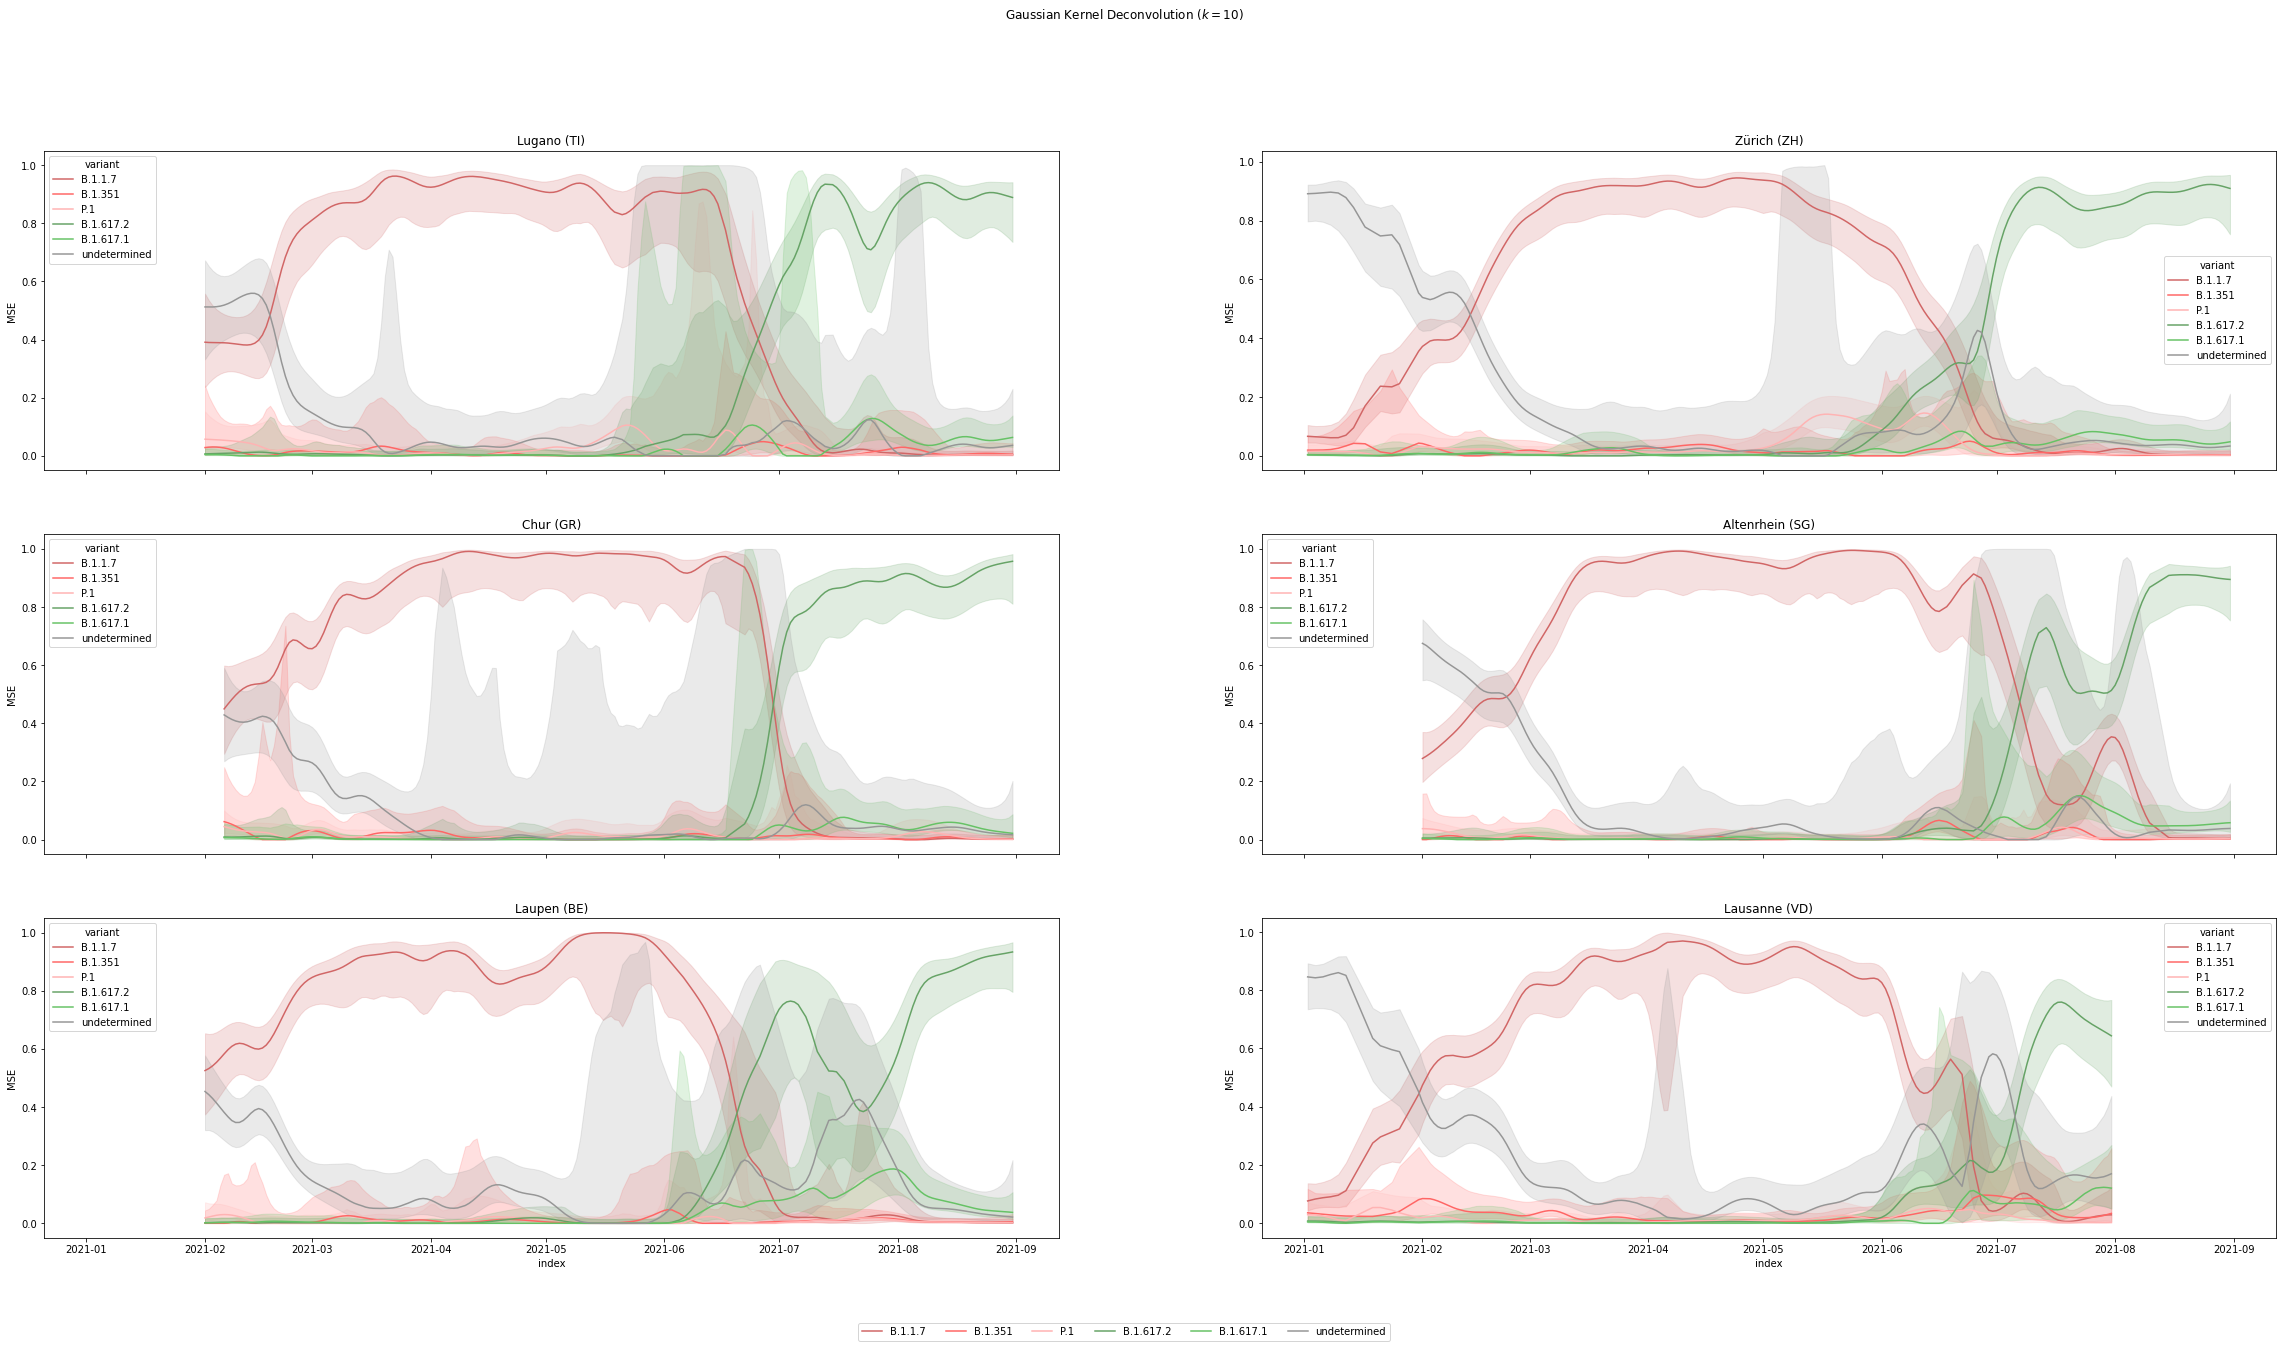

In [22]:
fig, axes = plt.subplots(nrows=3, ncols=2, figsize=(plotwidth, plotwidth/2), sharex=True)
axes = axes.flatten()

def logit_inv(x):
    return np.exp(x)/(1+np.exp(x))

for i, city in enumerate(linear_deconv2_quasi2_df_flat.city.unique()):
    axes[i].set_title(city)
    
    for var in linear_deconv2_quasi2_df_flat["variant"].unique():
        tt_df = linear_deconv2_quasi2_df_flat[
            (linear_deconv2_quasi2_df_flat["variant"] == var) &
            (linear_deconv2_quasi2_df_flat["city"] == city) 
        ].reset_index().pivot(
            index=["index", "city", "variant"],
            columns="estimate"
        ).reset_index()
        
        sns.lineplot(
            x=tt_df["index"], 
            y=tt_df["frac"]["MSE"], 
            hue=tt_df["variant"],
            ax = axes[i], 
            palette = color_map
        )
        axes[i].fill_between(
            x=tt_df["index"], 
            y1=logit_inv(np.clip(tt_df["frac"]["Wald_lower"], -100, 100)), 
            y2=logit_inv(np.clip(tt_df["frac"]["Wald_upper"], -100, 100)),
            alpha = 0.2,
            #color="grey"
            color=color_map[var],
        )
handles, labels = axes[i].get_legend_handles_labels()
fig.legend(handles, labels, loc='lower center', ncol=len(labels), bbox_to_anchor=(0.5,0.05))
fig.suptitle(f'Gaussian Kernel Deconvolution ($k=10$)')
# plt.savefig(os.path.join(plots_dir, f"combined-linear.pdf"))

### Do with Bootstrap Confints

In [23]:
%%time

np.random.seed(42)
n_boot = 1000
linear_deconv3 = []

for city in tqdm(cities_list):
    print(city)
    temp_df = preproc.df_tally[preproc.df_tally["plantname"] == city]
    for boot in tqdm(range(n_boot)):
        temp_df2 = resample_mutations(temp_df, temp_df.mutations.unique())[0]        
        t_kdec = KernelDeconv(
            temp_df2[variants_list + ["undetermined"]],
            temp_df2["frac"],
            temp_df2["date"],
            weights=temp_df2["resample_value"],
            kernel=GaussianKernel(30),
            reg=NnlsReg(),
            confint=NullConfint()
        )
        t_kdec = t_kdec.deconv_all(min_tol=1e-3)
        res = t_kdec.renormalize().fitted
        res["city"] = city
        linear_deconv3.append(res)
linear_deconv3_df = pd.concat(linear_deconv3)
linear_deconv3_df = linear_deconv3_df.fillna(0)

# backup data
# linear_deconv2_df.to_csv("linear_deconv2.csv")

  0%|          | 0/6 [00:00<?, ?it/s]

Lugano (TI)


  0%|          | 0/1000 [00:00<?, ?it/s]

Zürich (ZH)


  0%|          | 0/1000 [00:00<?, ?it/s]

Chur (GR)


  0%|          | 0/1000 [00:00<?, ?it/s]

Altenrhein (SG)


  0%|          | 0/1000 [00:00<?, ?it/s]

Laupen (BE)


  0%|          | 0/1000 [00:00<?, ?it/s]

Lausanne (VD)


  0%|          | 0/1000 [00:00<?, ?it/s]

CPU times: user 30min 2s, sys: 13 s, total: 30min 15s
Wall time: 30min 42s


#### aggregate boots

In [24]:
linear_deconv3_df = pd.concat(linear_deconv3)
linear_deconv3_df = linear_deconv3_df.fillna(0)

linear_deconv3_df_flat = linear_deconv3_df.melt(
    id_vars="city",
    value_vars=variants_list + ["undetermined"],
    var_name="variant",
    value_name="frac",
    ignore_index=False,
)

linear_deconv3_df_agg = linear_deconv3_df_flat.reset_index().groupby(["city", "index", "variant"]).agg(
    [np.std,
     lambda x: np.quantile(x, q=0.025),
     lambda x: np.quantile(x, q=0.975)]
).reset_index()
linear_deconv3_df_agg.head()

city      index    variant      frac                      
                                               std <lambda_0> <lambda_1>
0  Altenrhein (SG) 2021-02-01    B.1.1.7  0.045217   0.195859   0.371086
1  Altenrhein (SG) 2021-02-01    B.1.351  0.007027   0.000000   0.022758
2  Altenrhein (SG) 2021-02-01  B.1.617.1  0.002805   0.000000   0.010053
3  Altenrhein (SG) 2021-02-01  B.1.617.2  0.003936   0.000000   0.013523
4  Altenrhein (SG) 2021-02-01        P.1  0.028738   0.000000   0.104973

### plot

0it [00:00, ?it/s]

Text(0.5, 0.98, 'Gaussian Kernel Deconvolution ($k=10$)')

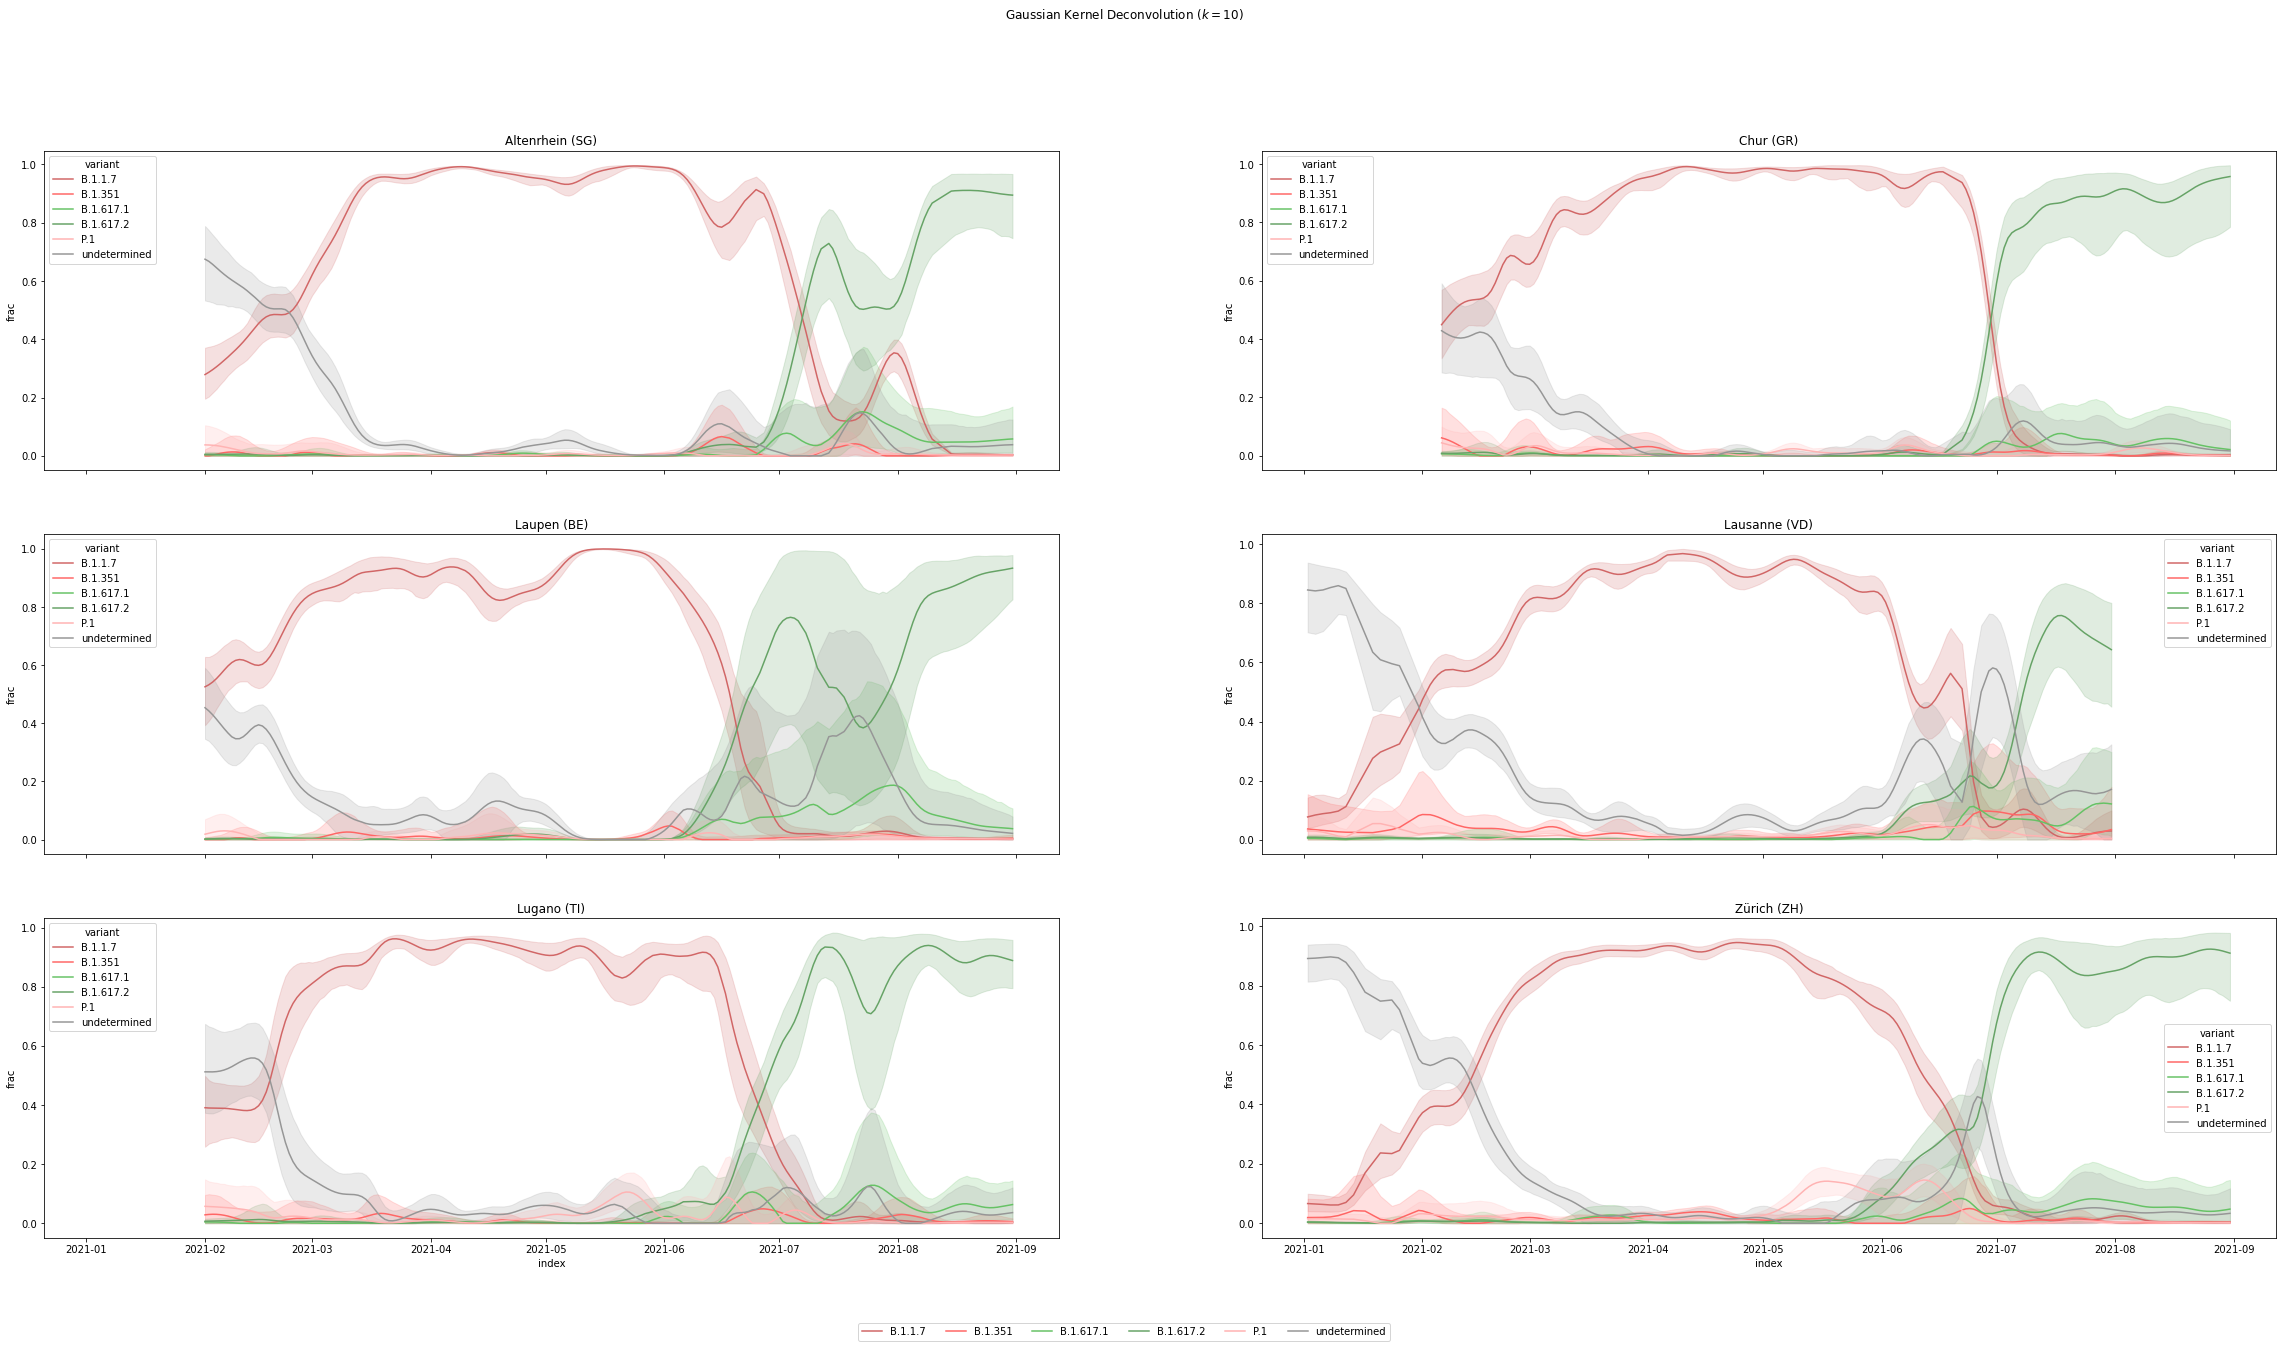

In [25]:
fig, axes = plt.subplots(nrows=3, ncols=2, figsize=(plotwidth, plotwidth/2), sharex=True)
axes = axes.flatten()

for i, city in tqdm(enumerate(linear_deconv3_df_agg.city.unique())):
    axes[i].set_title(city)
    
    for var in linear_deconv3_df_agg["variant"].unique():
        pp_df = linear_deconv_df_flat[
            (linear_deconv_df_flat["variant"] == var) &
            (linear_deconv_df_flat["city"] == city) &
            (linear_deconv_df_flat["estimate"] == "MSE")
        ].reset_index()
        tt_df = linear_deconv3_df_agg[
            (linear_deconv3_df_agg["variant"] == var) &
            (linear_deconv3_df_agg["city"] == city)
        ].reset_index()
        sns.lineplot(
            x=pp_df["index"], 
            y=pp_df["frac"], 
            hue=pp_df["variant"],
            ax = axes[i], 
            palette = color_map
        )
        axes[i].fill_between(
            x=tt_df["index"], 
            y1=tt_df["frac"]["<lambda_0>"], 
            y2=tt_df["frac"]["<lambda_1>"],
            alpha = 0.2,
            #color="grey"
            color=color_map[var],
        )
handles, labels = axes[i].get_legend_handles_labels()
fig.legend(handles, labels, loc='lower center', ncol=len(labels), bbox_to_anchor=(0.5,0.05))
fig.suptitle(f'Gaussian Kernel Deconvolution ($k=10$)')
# plt.savefig(os.path.join(plots_dir, f"combined-linear.pdf"))

## Do SL1 Deconv

In [26]:
%%time

np.random.seed(42)
robust_deconv = []

for city in tqdm(cities_list):
    print(city)
    temp_df2 = preproc.df_tally[preproc.df_tally["plantname"] == city]
    t_kdec = KernelDeconv(
        temp_df2[variants_list + ["undetermined"]],
        temp_df2["frac"],
        temp_df2["date"],
#         weights=temp_df2["resample_value"],
        kernel=GaussianKernel(30),
        reg=RobustReg(f_scale=0.135),
        confint=NullConfint()
    )
    t_kdec = t_kdec.deconv_all(min_tol=1e-3)
    res = t_kdec.renormalize().fitted.copy()
    res["city"] = city
    res["estimate"] = "robust"
    robust_deconv.append(res)
robust_deconv_df = pd.concat(robust_deconv)
# linear_deconv_df = linear_deconv_df.fillna(0)

robust_deconv_df_flat = robust_deconv_df.melt(
    id_vars=["city", "estimate"],
    value_vars=variants_list + ["undetermined"],
    var_name="variant",
    value_name="frac",
    ignore_index=False,
)

# backup data
# linear_deconv2_df.to_csv("linear_deconv2.csv")

  0%|          | 0/6 [00:00<?, ?it/s]

Lugano (TI)
Zürich (ZH)
Chur (GR)
Altenrhein (SG)
Laupen (BE)
Lausanne (VD)
CPU times: user 2min 3s, sys: 2min 4s, total: 4min 7s
Wall time: 1min


### Plot

Text(0.5, 0.98, 'Gaussian Kernel Deconvolution ($k=10$)')

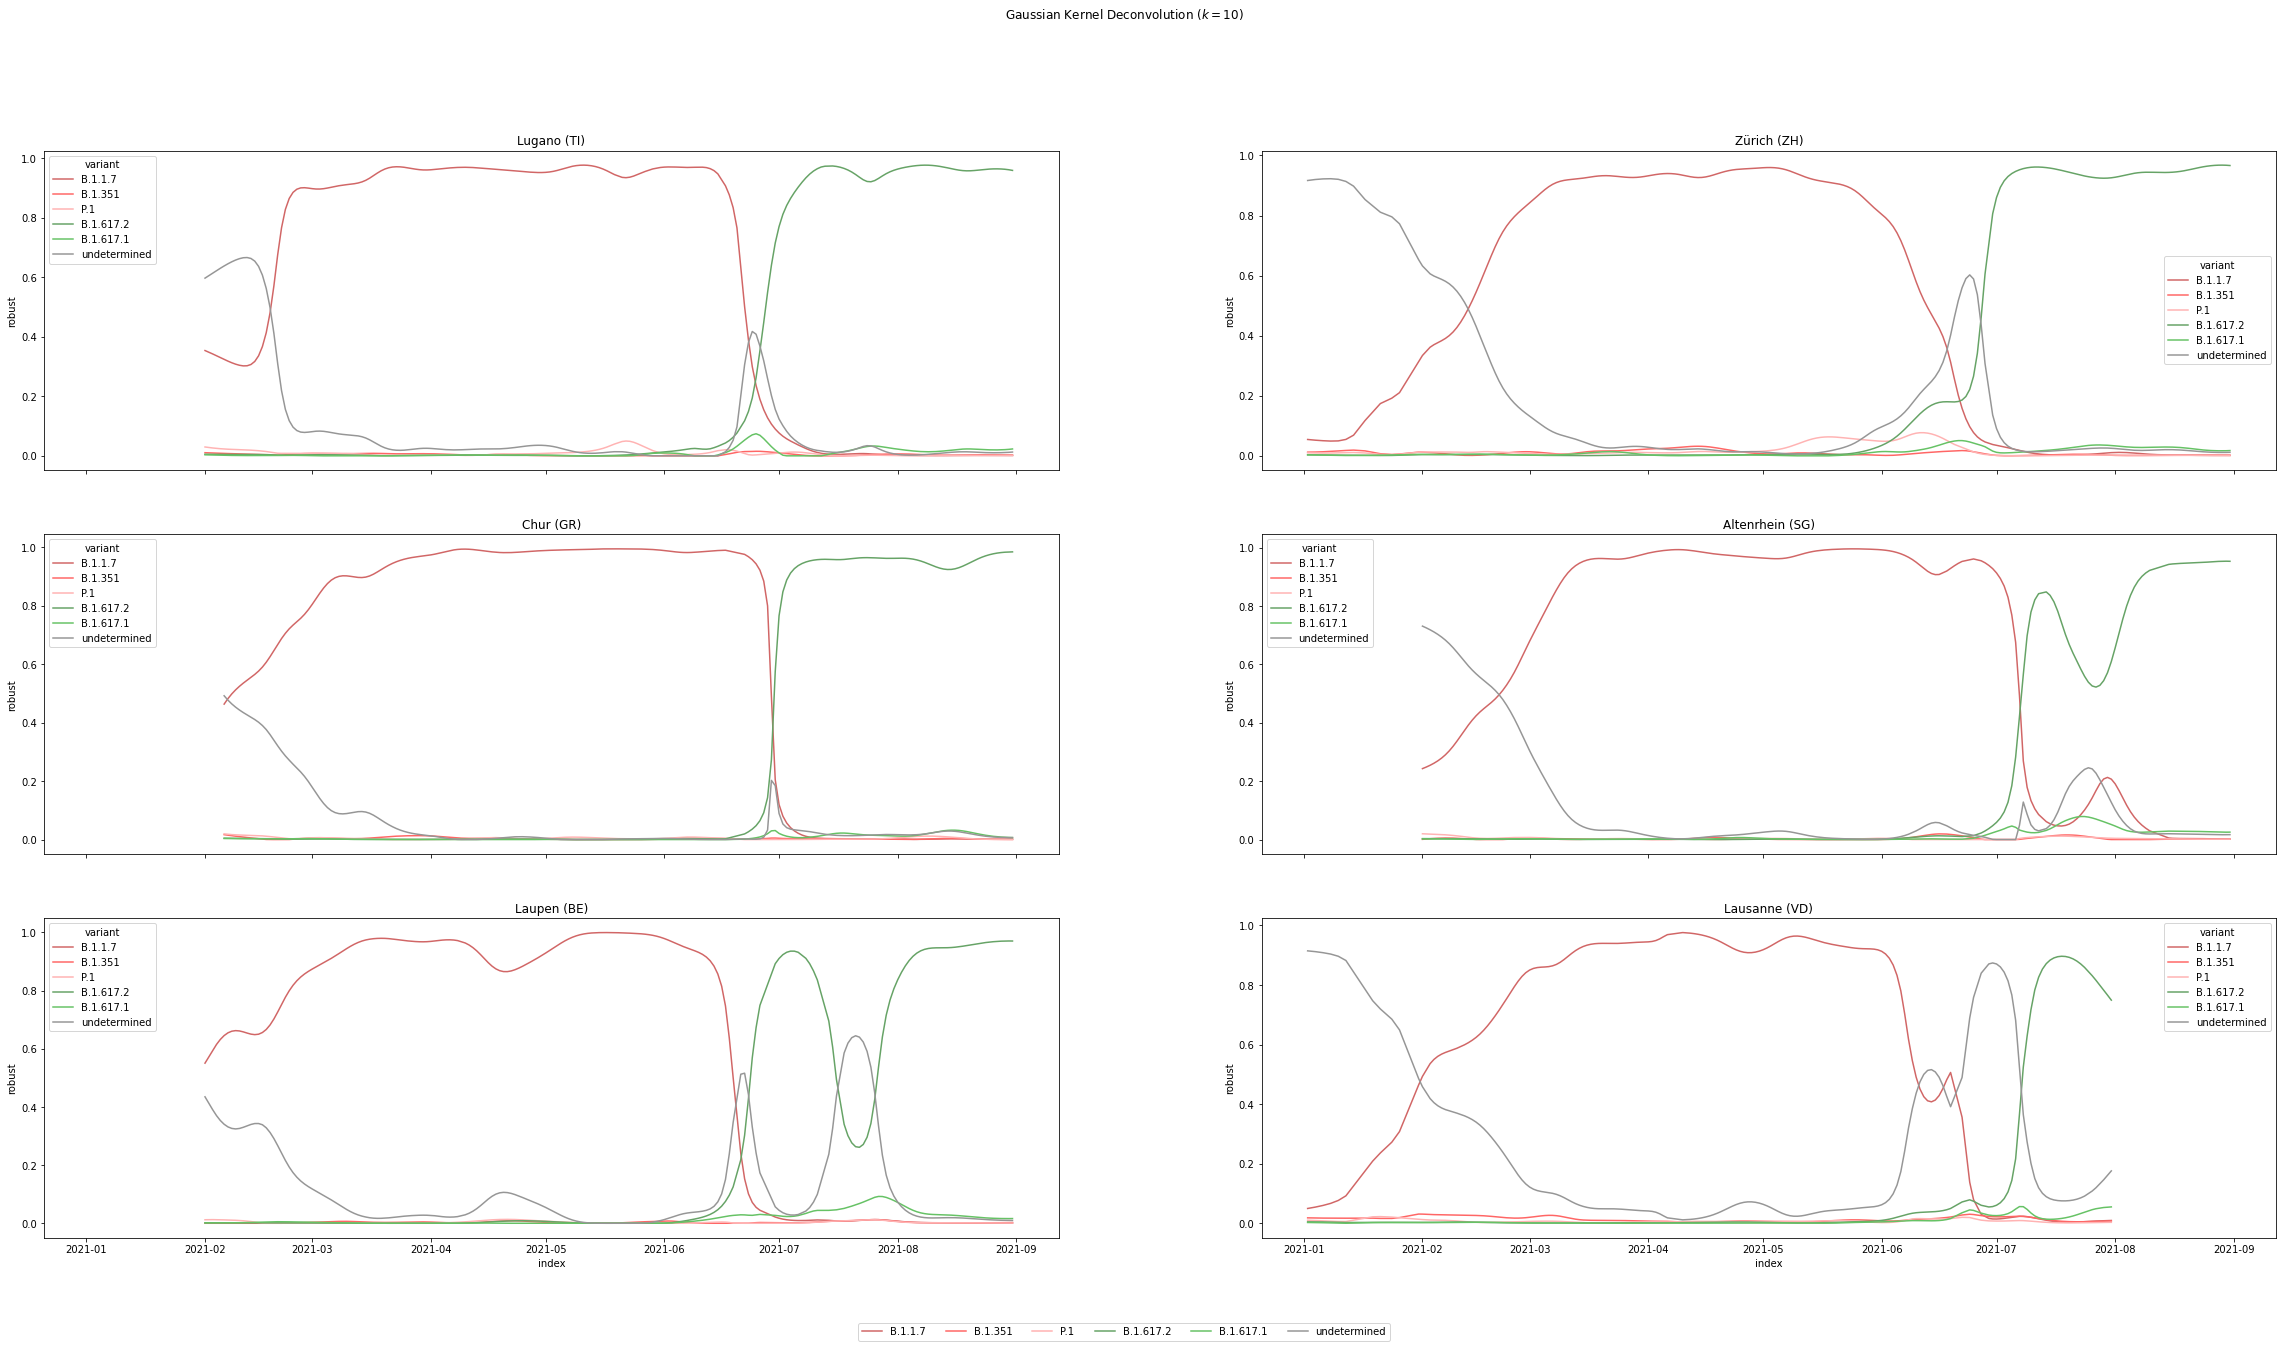

In [27]:
fig, axes = plt.subplots(nrows=3, ncols=2, figsize=(plotwidth, plotwidth/2), sharex=True)
axes = axes.flatten()

for i, city in enumerate(robust_deconv_df_flat.city.unique()):
    axes[i].set_title(city)
    
    for var in robust_deconv_df_flat["variant"].unique():
        tt_df = robust_deconv_df_flat[
            (robust_deconv_df_flat["variant"] == var) &
            (robust_deconv_df_flat["city"] == city) 
        ].reset_index().pivot(
            index=["index", "city", "variant"],
            columns="estimate"
        ).reset_index()
        
        sns.lineplot(
            x=tt_df["index"], 
            y=tt_df["frac"]["robust"], 
            hue=tt_df["variant"],
            ax = axes[i], 
            palette = color_map
        )
#         axes[i].fill_between(
#             x=tt_df["index"], 
#             y1=tt_df["frac"]["Wald_lower"], 
#             y2=tt_df["frac"]["Wald_upper"],
#             alpha = 0.2,
#             #color="grey"
#             color=color_map[var],
#         )
handles, labels = axes[i].get_legend_handles_labels()
fig.legend(handles, labels, loc='lower center', ncol=len(labels), bbox_to_anchor=(0.5,0.05))
fig.suptitle(f'Gaussian Kernel Deconvolution ($k=10$)')
# plt.savefig(os.path.join(plots_dir, f"combined-linear.pdf"))

# Output

In [28]:
linear_deconv_df_flat.reset_index().to_csv("out/linear_deconv_df_flat.csv", index=False)

In [29]:
robust_deconv_df_flat.reset_index().to_csv("out/robust_deconv_df_flat.csv", index=False)

In [30]:
linear_deconv_df_flat.to_csv("out/linear_deconv_df_flat.csv")
linear_deconv2_df_flat.to_csv("out/linear_deconv2_df_flat.csv")

linear_deconv_quasi2_df_flat.to_csv("out/linear_deconv_quasi2_df_flat.csv")
linear_deconv2_quasi2_df_flat.to_csv("out/linear_deconv2_quasi2_df_flat.csv")

linear_deconv3_df_aggb = linear_deconv3_df_agg.copy()

linear_deconv3_df_aggb.columns = ["city", "index", "variant", "std", "lower", "upper"]

linear_deconv3_df_boot_flat = linear_deconv3_df_aggb.melt(
    id_vars = ["city", "index", "variant"],
    value_vars= ["lower", "upper"],
    var_name="estimate",
    value_name="frac"
)

linear_deconv3_df_boot_flat.to_csv("out/linear_deconv3_df_boot_flat.csv")

# Tune hyperparams

In [31]:
cities_list_short = ["Zürich (ZH)", "Lausanne (VD)"]

## LS

In [32]:
np.random.seed(42)
linear_deconv_hyp = []

kernel_vals = np.append(np.array([0.001]), np.linspace(1,60, 60), axis=0)
os.remove("out/linear_deconv_df_hyperparam.csv")

for i, kval in enumerate(tqdm(kernel_vals)):
    for j, city in enumerate(cities_list_short):
#         print(city)
        temp_df2 = preproc.df_tally[preproc.df_tally["plantname"] == city]
        t_kdec = KernelDeconv(
            temp_df2[variants_list + ["undetermined"]],
            temp_df2["frac"],
            temp_df2["date"],
    #         weights=temp_df2["resample_value"],
            kernel=GaussianKernel(kval),
            reg=NnlsReg(),
            confint=NullConfint()
        )
        t_kdec = t_kdec.deconv_all()
        res = t_kdec.fitted
        res["city"] = city
        res["k"] = kval
        
        if i+j==0:
            res.to_csv("out/linear_deconv_df_hyperparam.csv", mode="a")
        else:
            res.to_csv("out/linear_deconv_df_hyperparam.csv", header=False, mode="a")
            


  0%|          | 0/61 [00:00<?, ?it/s]

## SL1

In [39]:
np.linspace(0.01, 1, 25)

array([0.01   , 0.05125, 0.0925 , 0.13375, 0.175  , 0.21625, 0.2575 ,
       0.29875, 0.34   , 0.38125, 0.4225 , 0.46375, 0.505  , 0.54625,
       0.5875 , 0.62875, 0.67   , 0.71125, 0.7525 , 0.79375, 0.835  ,
       0.87625, 0.9175 , 0.95875, 1.     ])

In [33]:
np.random.seed(42)
linear_deconv_hyp = []

os.remove("out/robust_deconv_df_hyperparam.csv")

kernel_vals = np.append(np.array([0.001]), np.linspace(5,30, 6), axis=0)
kappa_vals = np.linspace(0.01, 1, 25)

for kval in tqdm(kernel_vals):
    for kap in kappa_vals:    
        for city in cities_list_short:
    #         print(city)
            temp_df2 = preproc.df_tally[preproc.df_tally["plantname"] == city]
            t_kdec = KernelDeconv(
                temp_df2[variants_list + ["undetermined"]],
                temp_df2["frac"],
                temp_df2["date"],
        #         weights=temp_df2["resample_value"],
                kernel=GaussianKernel(kval),
                reg=RobustReg(f_scale=kap),
                confint=NullConfint()
            )
            t_kdec = t_kdec.deconv_all(min_tol=1e-3)
            res = t_kdec.fitted
            res["city"] = city
            res["k"] = kval
            res["kappa"] = kap

            res.to_csv("out/robust_deconv_df_hyperparam.csv", mode="a")
        
#         linear_deconv.append(res)
# linear_deconv_df = pd.concat(linear_deconv)
# linear_deconv_df = linear_deconv_df.fillna(0)

# linear_deconv_df_flat = linear_deconv_df.melt(
#     id_vars="city",
#     value_vars=variants_list + ["undetermined"],
#     var_name="variant",
#     value_name="frac",
#     ignore_index=False,
# )

  0%|          | 0/7 [00:00<?, ?it/s]

In [34]:
temp_df2 = preproc.df_tally[preproc.df_tally["plantname"] == "Zürich (ZH)"]
t_kdec = KernelDeconv(
        temp_df2[variants_list + ["undetermined"]],
        temp_df2["frac"],
        temp_df2["date"],
        kernel=GaussianKernel(30),
        reg=NnlsReg(),
        confint=WaldConfint()
    )
date = np.datetime64("2021-02-20")
min_tol = 1e-3
pseudofrac = 0.01
kvals = (
            t_kdec.kernel.values(0, (date - t_kdec.dates) / pd.to_timedelta(1, unit="D"))
            * t_kdec.weights
        )
rfit = t_kdec.deconv(date = date, min_tol=1e-3)

WC = WaldConfint()
SE = WC.standard_error(
            t_kdec.X.values[kvals.values >= min_tol, :]
            * np.expand_dims(kvals.values[kvals.values >= min_tol], 1),
            rfit.fitted,
        )
CI = WC.confint(
    t_kdec.X.values[kvals.values >= min_tol, :]
    * np.expand_dims(kvals.values[kvals.values >= min_tol], 1),
    rfit.fitted,
    t_kdec.y.values[kvals.values >= min_tol],
    kvals[kvals.values >= min_tol] 
)

WC2 = WaldConfint(quasi=True)
CI2 = WC2.confint(
    t_kdec.X.values[kvals.values >= min_tol, :]
    * np.expand_dims(kvals.values[kvals.values >= min_tol], 1),
    rfit.fitted,
    t_kdec.y.values[kvals.values >= min_tol],
    kvals[kvals.values >= min_tol] 
)

WC3 = WaldConfint(quasi=True, method="strat")
CI3 = WC3.confint(
    t_kdec.X.values[kvals.values >= min_tol, :]
    * np.expand_dims(kvals.values[kvals.values >= min_tol], 1),
    rfit.fitted,
    t_kdec.y.values[kvals.values >= min_tol],
    kvals[kvals.values >= min_tol] 
)

WC4 = WaldConfint(quasi=True, method="strat", scale="logit")
CI4 = WC4.confint(
    t_kdec.X.values[kvals.values >= min_tol, :]
    * np.expand_dims(kvals.values[kvals.values >= min_tol], 1),
    rfit.fitted,
    t_kdec.y.values[kvals.values >= min_tol],
    kvals[kvals.values >= min_tol] 
)

print(pd.DataFrame(CI))
print(pd.DataFrame(CI2))
print(pd.DataFrame(CI3))
print(pd.DataFrame(CI4))


      lower     upper
0  0.618318  0.704098
1 -0.006267  0.019141
2  0.005689  0.037838
3 -0.003996  0.017191
4 -0.006158  0.024387
5  0.246884  0.342875
      lower     upper
0  0.615088  0.707328
1 -0.007224  0.020097
2  0.004478  0.039049
3 -0.004794  0.017989
4 -0.007308  0.025537
5  0.243270  0.346489
      lower     upper
0  0.629936  0.692480
1 -0.004216  0.017089
2  0.015764  0.027763
3  0.001265  0.011929
4 -0.000441  0.018670
5  0.256967  0.332792
      lower     upper
0  0.382721  0.941504
1 -8.215495 -1.723632
2 -4.364474 -3.206720
3 -6.646970 -3.245888
4 -6.760680 -2.517679
5 -1.248174 -0.499110


/Users/gneiss/Documents/School/CBG2/brexit/TSmodelling/WWdeconvolution/RECOMBpaper/../Dev/WWdec/confints.py:54: RuntimeWarning: invalid value encountered in true_divide
  overdisp_agg = (np.expand_dims(overdisp_vals,1) * X[mut_ind,:]).sum(axis=0)  / norm


In [35]:
yy = t_kdec.y.values[kvals.values >= min_tol]
yy_hat = t_kdec.X.values[kvals.values >= min_tol, :].dot(rfit.fitted)
yy_hat = yy_hat + pseudofrac
yy_hat = yy_hat / (yy_hat + (1 - yy_hat + 2 * pseudofrac))

expected_var = yy_hat * (1-yy_hat)

In [36]:
((((yy - yy_hat)**2) / expected_var) * kvals[kvals.values >= min_tol] / kvals[kvals.values >= min_tol].sum()).sum()

0.184228884875356

In [37]:
mut_ind = ~temp_df2["mutations"].str.startswith("-")[kvals.values >= min_tol]
overdisp_vals = (
    (((yy - yy_hat)**2) / expected_var) *
    kvals[kvals.values >= min_tol] 
)[mut_ind]
                 
norm = (
    np.expand_dims(kvals.values[kvals.values >= min_tol], 1) * 
    t_kdec.X.values[kvals.values >= min_tol, :]
)[mut_ind,:].sum(axis=0)

overdisp_agg = (np.expand_dims(overdisp_vals,1) * t_kdec.X.values[kvals.values >= min_tol, :][mut_ind,:]).sum(axis=0)  / norm
overdisp_agg[-1] = overdisp_vals.sum() / kvals[kvals.values >= min_tol][mut_ind].sum()
overdisp_agg
# t_kdec.X

/var/folders/yt/sy9k0v5j5614lbn7g01dkf6r0000gn/T/ipykernel_32489/967815346.py:12: RuntimeWarning: invalid value encountered in true_divide
  overdisp_agg = (np.expand_dims(overdisp_vals,1) * t_kdec.X.values[kvals.values >= min_tol, :][mut_ind,:]).sum(axis=0)  / norm


array([0.36807473, 0.27907402, 0.09516393, 0.13065449, 0.19764587,
       0.18422888])

In [38]:
SE * overdisp_agg * 4

array([0.0322187 , 0.00723551, 0.00312196, 0.00282477, 0.00616048,
       0.01804564])